# PHASE 3 SUBMISSION: Image Classifier for Kitties and Puppies
--------------------------------
Group 2:
Scott Sirk
Patrick Sovereign
Andy Goldfarb
Priyank Sharma

## Abstract


Computer vision and deep learning are fast moving concepts in machine learning that are actively being researched and improved. Group 2 is attempting to solve the problem of classifying color images of cats and dogs while simultaneously performing an object localization task via machine learning. The group was interested in exploring problem space defined by programmatically processing image contents and transforming image data to an acceptable format to be interpretted by the computer to allow for a trained machine learning model to accurate predict an image label and locate objects inside the iamge. To perform this task programmatically the group explored 5 different implementations starting with a simple logistic regression classifier and moving to a custom fully convolutional neural network. Our results showed that networks comprised of only dense layers perform poorly during both the tasks. The fully convolutional networks perform at much higher rate of accuracy due due to the ability to create feature maps identifying defining features in an image. The following notebook explores the impact of increasingly complex and custom network architectures on the performance of two prediction tasks for classification and regression. 

## Project Description

The final deliverable of the work of the team is a notebook documenting the data transfer, exploratory data analysis, and network creation for 5 different implementations of architectures to classify and locate an object in an image. The goal of the team was to create a homegrown logitstic regression approach to the classification problem which resulted in about a 51% accuracy, a bit better than randomly guessing and see how much we can imporve from this benchmark. We developed a process to reduce the dataset to images that we felt would provide the best training set and then took an increasingly complex approach to defiing our network architecture as we learned more about deep learning through our research. We started with a OOP linear network with a defined forward propagation method, then a sequential linear network that is defined at runtime. These methods were only slightly better at each task than the basic homegrown logisitic approach at around 57% accuracy. Finally, we implmented a transfer learning approach and saw drastic increases in performance of the model to an average of 93% accuracy in the classification task and around 66% on the bounding box task. 

#### Preprocessing steps

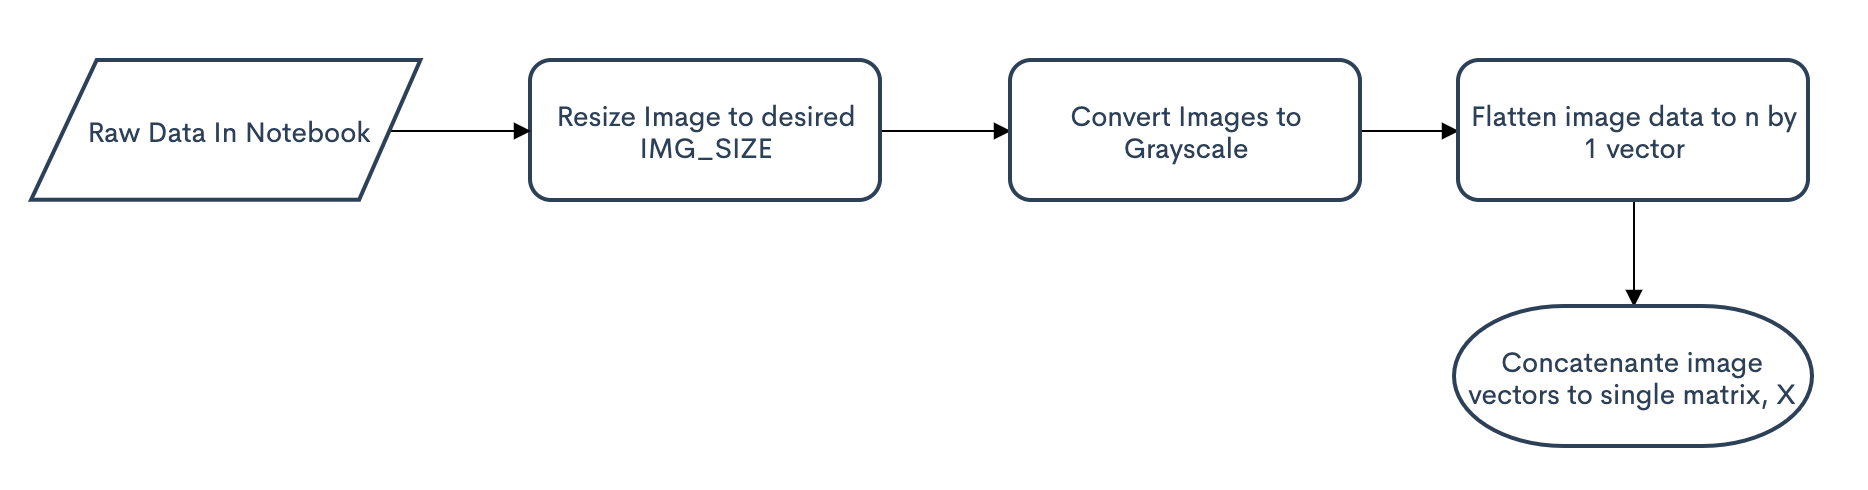

#### Linear Model Training

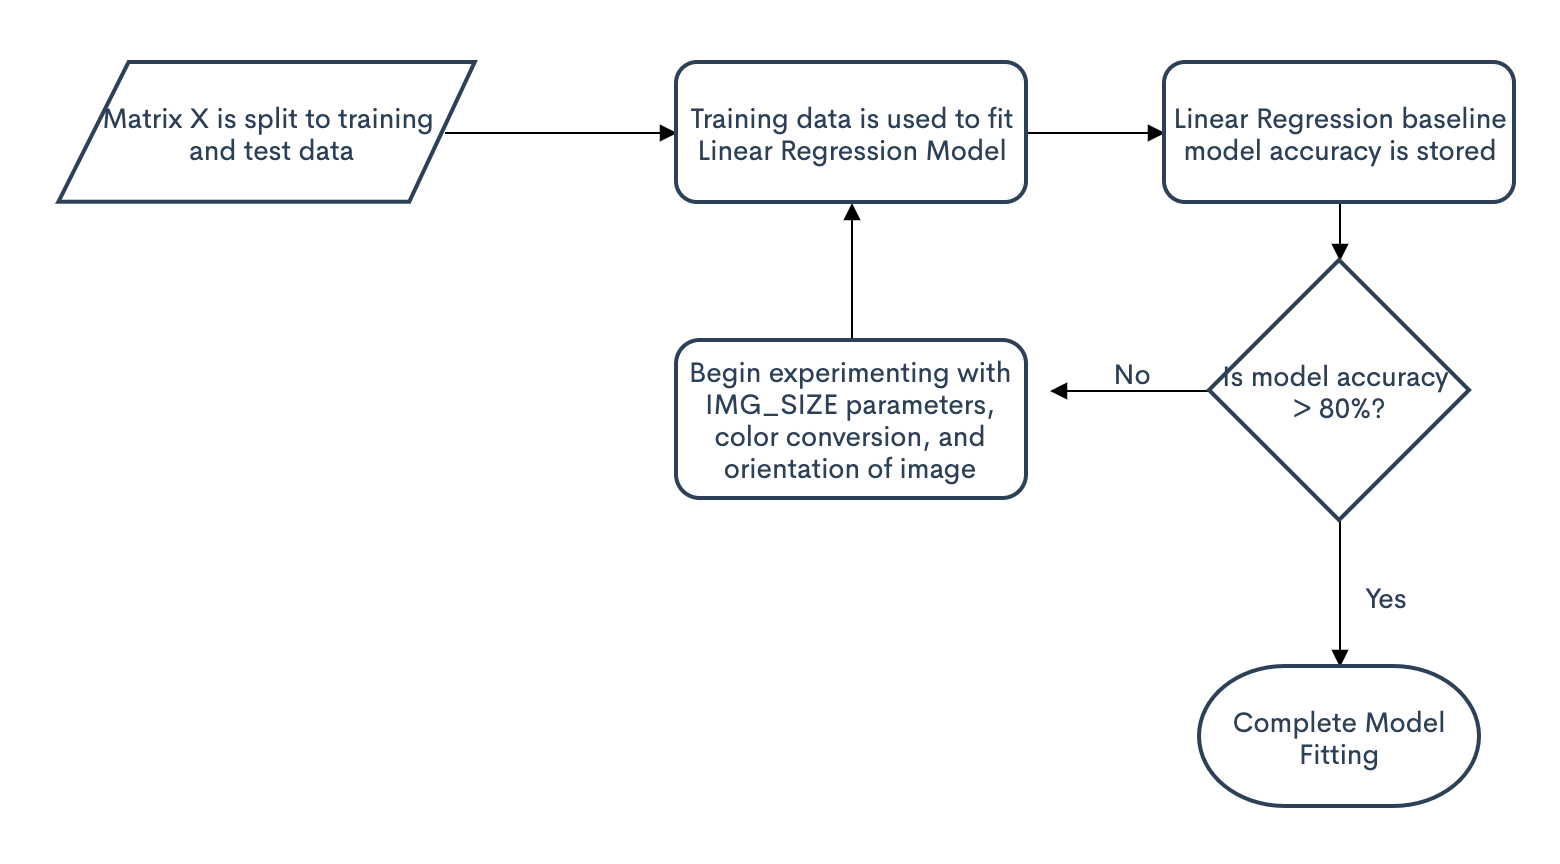
 

#### NN Steps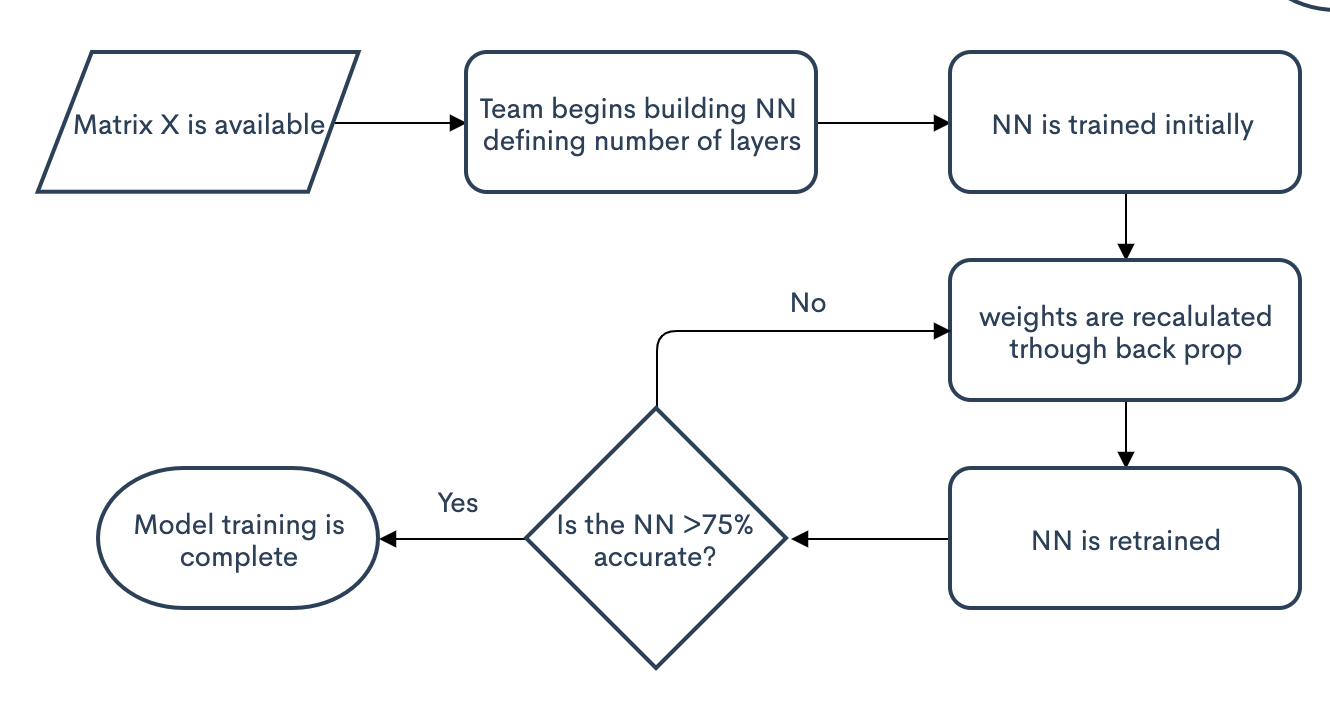


Pytorch implementation

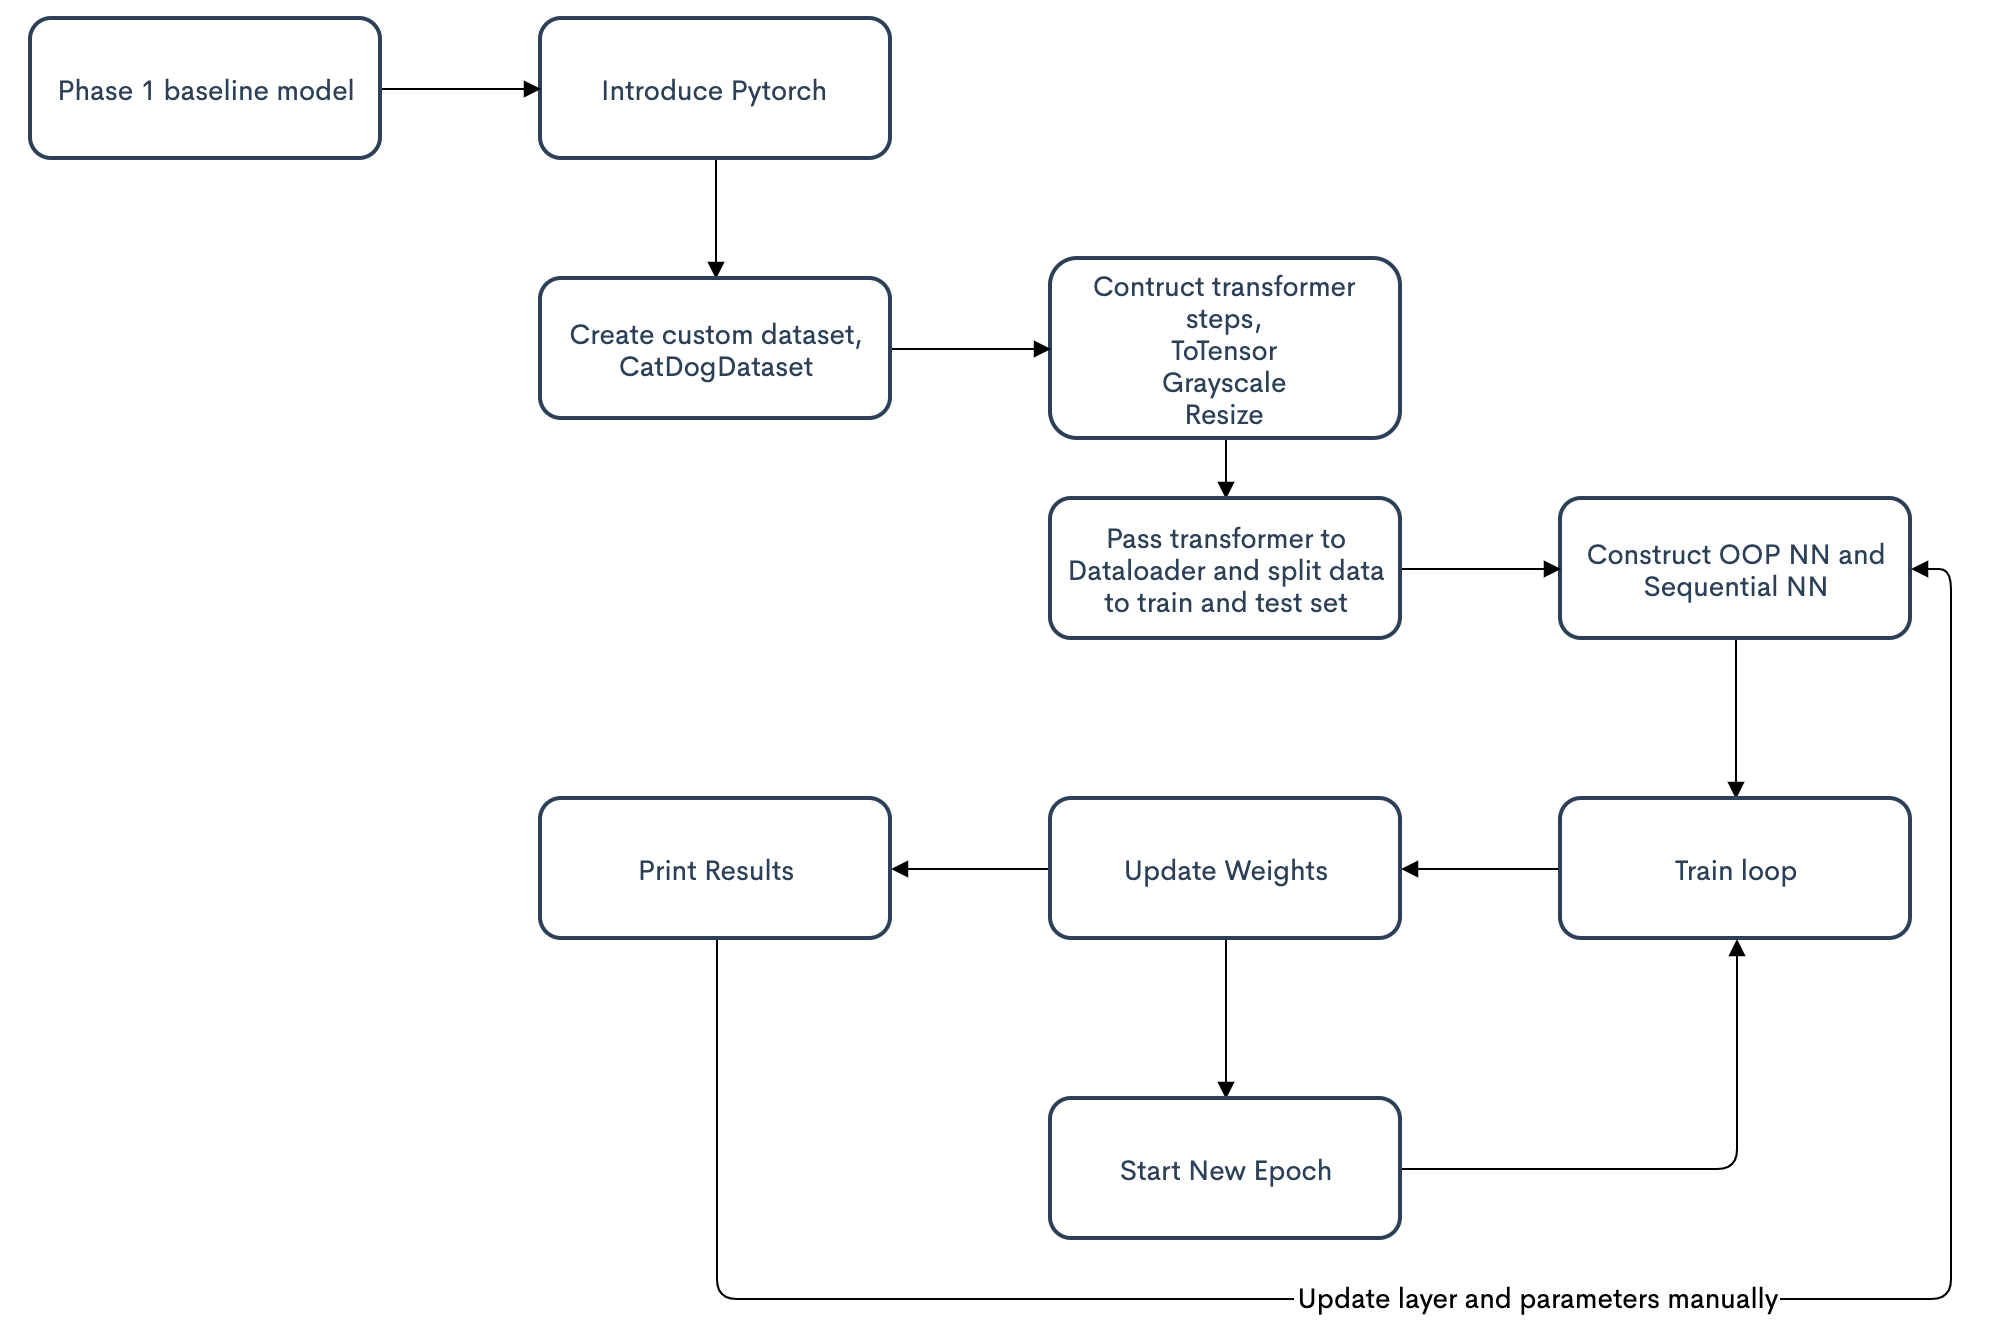





### Data

The data being used to train the models in this project is a set of about 44,000 images of cats and dogs. The images also have corresponding bounding box information which surrounds the identified cat or dog in the image to locate specifically where it exists in the image. Each image was manually labeled and located by a human to complete the dataset. Each image has meta data to identify the bounding box corner locations and if the subject of the photo is:

- occluded
- in a group
- a drawing
- inside a building
- truncated by the framing of the photo

To account for expected noise in this dataset such as bad images, images of animals very far away and impossible to detect, or images of things that are not dogs or cats we first set out to redcue the dataset to something a bit more controlled. We created a calculated column of the area of the bounding box in each image. We then filtered the dataset to only include images that have a bounding box area larger than 0.4 to reduce the effort of the network spent training on images that had a small subject which could introduce bad training results. After this filter we reduced the dataset down to 15336 images, which 15001 being unique images. The dataset at this point is 54% dogs and 46% cats. We did not attempt to balance the datasets, instead opting to introduce random stratifying during the creation of training, test, and validation sets. The training set was left to be 72% of the total data and 10% was allocated to the test set.

### Models

Our team explored the following model architectures:

1. Homegrown Logisitc Regression
2. OOP Linear NN
3. Sequential Linear NN
4. Transfer Learning with ResNet 50
5. Custom Fully CNN

#### Homegrown Logistic Regression

#### OOP Linear NN

#### Sequential Linear NN

This model is trained from scratch for all params just like the OOP Linear NN. This architecture has the exact same architecture as the OOP Linear NN, it is just a different implementation. Our team did not implement a custom forward prop function for the sequential NN. The performance of this model and the OOP Linear NN was about the same. It can be expected that a sequential NN and an OOP NN with the same architectures will perform about the same because the layer shape, activation functions, and dropout layers will perform about the same regardless of implementation method if the data passed through is the same.

#### Transfer Learning with ResNet 50

This model is based on the pretrained ResNet 50 architecture that is part of PyTorch. We added to this model to change the last layer of the model output two different ways. Each model based on resnet50 has the parameters for any pretrained convolutional layer set to remain untrained. The model for our project only trains the last layer of the prebuilt resnet model and nay additional layers we added.

##### Hybrid Model Approach

Built on top of the base resnet50 model we added a new final layer that will output 2 values for the classifier and 4 values for the bounding box info. The bounding box info was re-engineered to provide the center x and y coordinates, height, and width. This model is convolutional until the final two layers which are dense layers, resulting in a hybrid model. The performance of this model in the classification task averaged around 93% a significant increase from the homegrown logisitic regression and about a 66% on the bounding box task which is better than our zero percent we got when we could not figure out this aspect early on in the project.

##### Fully Connected NN

This model is built on top of resnet50 as well. The last layer was also altered to remove the final dense layer with 1000 outputs and replace it with a convolutional layer to create a fully convolution network. The last layer performs a 1 by 1 convolution before returning two outputs for the classification task and 4 outputs for the bounding box size task. The final convolutional layer allows the model to create a final feature map and identify significant features in the last layer resulting in imporved performance vs the dense layers.


#### Custom Fully CNN

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pprint
from skimage import data
import cv2
import glob
import re
import tarfile
import pathlib
import pickle
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
import warnings
from time import time
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
from torchvision import transforms, utils
import os
import torch
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
from collections import namedtuple
from itertools import product
from PIL import Image

# Phase 1: Scikit-Learn Baseline Models

In [ ]:
def extract_data(file_name):
    with tarfile.open(file_name, 'r') as data:
        # Print all the contents of the tar file
        data.list(verbose=False)
        
        # Extract all files
        print('Extracting all the files now...')
        data.extractall('/content/drive/MyDrive/AML Final Project/cat_dog/')
        data.close()
        print('Done!')

## Exploratory Data Analysis + Feature Engineering

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AML Final Project/cat_dog_boxes.csv')

In [ ]:
##file sizes - total and average
import os

file_locn = '/content/drive/MyDrive/AML Final Project/cat_dog'
all_file_sizes = []
for f in os.listdir(file_locn):
  file_size = os.path.getsize(file_locn + '/' + f)
  all_file_sizes.append(file_size)

print('Total Size:', sum(all_file_sizes) * 0.001, 'KB')
print('Average Image Size:', sum(all_file_sizes)/len(all_file_sizes) * 0.001, 'KB')

OSError: ignored

            ImageID  Source  LabelName  ...  XClick2Y  XClick3Y  XClick4Y
0  0000b9fcba019d36  xclick  /m/0bt9lr  ...  0.506667  0.998333  0.661667
1  0000cb13febe0138  xclick  /m/0bt9lr  ...  0.410882  0.999062  0.999062
2  000256419f7c57d8  xclick  /m/0bt9lr  ...  0.549167  0.650000  0.603333
3  000256419f7c57d8  xclick  /m/0bt9lr  ...  0.491667  0.543333  0.598333
4  000256419f7c57d8  xclick  /m/0bt9lr  ...  0.550000  0.584167  0.592500

[5 rows x 21 columns] 

(43858, 21)
Dog Images: 15183
Cat Images: 28675
Total Images: 43858
(32892,)


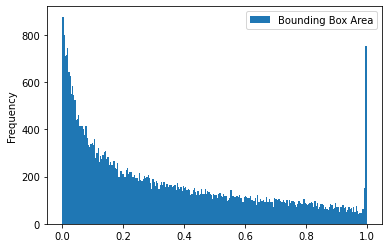

In [ ]:
#show a distribution of bounding box sizes(using csv metadata provided)
import pandas as pd
import numpy as np

#show first few rows of data
print(df.head(), '\n')
#show total size of dataframe
print(df.shape)
len(os.listdir("/content/drive/MyDrive/AML Final Project/cat_dog/"))
#count dog/cat images
dog_row_count = len(df.loc[df['LabelName'] == '/m/01yrx'])
cat_row_count = len(df.loc[df['LabelName'] == '/m/0bt9lr'])
#display counts
print('Dog Images:', dog_row_count)
print('Cat Images:', cat_row_count)
print('Total Images:', len(df))

#Print unique items
print(df.ImageID.unique().shape)

#calc box sizes
#get mix (X, Y)
min_coors = df[['XMin', 'YMin']].to_numpy()
#get max(X, Y)
max_coors = df[['XMax', 'YMax']].to_numpy()
#take max_x - min_x and max_y - min_y to get the height and width of the box
width_x_height_matrix = np.subtract(max_coors, min_coors)
#get width/height into their own vectors - feels kinda clumsy probably a better way to do this
widths = width_x_height_matrix[:,0]
heights = width_x_height_matrix[:,1]
#get a vector of areas(width*height)
areas = np.multiply(widths, heights)
#throw those areas into a dataframe to display a distribution
areas_df = pd.DataFrame(areas, columns = ['Bounding Box Area'])
#display the frequency of bounding box size as a histogram
areas_hist = areas_df.plot.hist(bins = 250)



In [ ]:
# only manually drawn bbox
df = df[df.Source == 'xclick']

# not occluded
#df = df[df.IsOccluded == 0]

# not truncated
#df = df[df.IsTruncated == 0]

# not in a group
df = df[df.IsGroupOf == 0]

# not depiction
df = df[df.IsDepiction == 0]

In [ ]:
df['area'] = (df.XMax - df.XMin) * (df.YMax - df.YMin)

# images that are more than 40% of the entire image
df = df[df.area > 0.4]

In [ ]:
df.LabelName.replace({'/m/01yrx':'cat', '/m/0bt9lr':'dog'}, inplace=True)
df.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y,area
0,0000b9fcba019d36,xclick,dog,1,0.165000,0.903750,0.268333,0.998333,1,1,0,0,0,0.636250,0.903750,0.748750,0.165000,0.268333,0.506667,0.998333,0.661667,0.539288
1,0000cb13febe0138,xclick,dog,1,0.000000,0.651875,0.000000,0.999062,1,1,0,0,0,0.312500,0.000000,0.317500,0.651875,0.000000,0.410882,0.999062,0.999062,0.651264
11,0005a9520eb22c19,xclick,dog,1,0.094167,0.611667,0.055626,0.998736,1,1,0,0,0,0.487500,0.611667,0.243333,0.094167,0.055626,0.226296,0.998736,0.305942,0.488059
12,0006303f02219b07,xclick,dog,1,0.000000,0.999219,0.000000,0.998824,1,1,0,0,0,0.508594,0.999219,0.000000,0.478906,0.000000,0.375294,0.720000,0.998824,0.998044
13,00064d23bf997652,xclick,dog,1,0.240938,0.906183,0.000000,0.694286,0,0,0,0,0,0.678038,0.906183,0.240938,0.522388,0.000000,0.370000,0.424286,0.694286,0.461870


In [ ]:
datadir = "/content/drive/MyDrive/AML Final Project/cat_dog/"

# plot random 6 images
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(df.shape[0], size=6, replace=False)):
    try:
        img = mpimg.imread(datadir + df.ImageID.values[j] + '.jpg')
        h, w = img.shape[:2]
        coords = df.iloc[j,4:8]
        ax[i].imshow(img)
        ax[i].set_title(df.iloc[j,2])
        ax[i].add_patch(plt.Rectangle((coords[0]*w, coords[2]*h), 
                                    coords[1]*w-coords[0]*w, coords[3]*h-coords[2]*h, 
                                    edgecolor='red', facecolor='none'))
    except FileNotFoundError:
        print("not loaded")

plt.tight_layout()
plt.show()

## Preprocessing

In [ ]:
from PIL import Image

In [ ]:
#!mkdir -p "/content/drive/My Drive/AML Final Project/resized"

In [ ]:
%%time
# resize image and saving, convert to numpy, bring into memory as df

#path = "/content/drive/My Drive/AML Final Project/cat_dog/"
path = "/content/drive/My Drive/AML Final Project/cat_dog/resized/" # Comment this and uncomment line above if running for first time

files = df.iloc[:,[0,2]].reset_index()

X_list = []
y_list = []
bound_box = []

for idx, f in enumerate(files.ImageID):
    try:
        img = Image.open(path+f+'.jpg')
        #img_resized = img.resize((128,128))
        #img_resized.save("/content/drive/My Drive/AML Final Project/cat_dog/resized/"+f+'.jpg', "JPEG", optimize=True)
        #X_list.append(np.asarray(img_resized))
        X_list.append(np.asarray(img)) # Comment this and uncomment the three lines above if running for first time
        y_list.append(files.LabelName[idx])
        bound_box.append(np.asarray(df.iloc[idx,4:8]))
    except FileNotFoundError:
        pass

KeyboardInterrupt: ignored

In [ ]:
# Pickle the resized image data and class labels to make loading quicker
'''import pickle

img_pickle = open("/content/drive/My Drive/AML Final Project/image_data.pickle", "wb")
pickle.dump(X_list, img_pickle)
img_pickle.close()

y_pickle = open("/content/drive/My Drive/AML Final Project/y_data.pickle", "wb")
pickle.dump(y_list, y_pickle)
img_pickle.close()

bbox_pickle = open("./data/bbox_data.pickle", "wb")
pickle.dump(bound_box, bbox_pickle)
bbox_pickle.close()'''

In [ ]:
# Unpickle the data (much faster than resizing images)
img_file = open("/content/drive/MyDrive/AML Final Project/image_data.pickle", "rb")
X_list = pickle.load(img_file)
img_file.close()

y_file = open("/content/drive/MyDrive/AML Final Project/y_data.pickle", "rb")
y_list = pickle.load(y_file)
y_file.close()

bbox_file = open("/content/drive/MyDrive/AML Final Project/bbox_data.pickle", "rb")
bound_box = pickle.load(bbox_file)
bbox_file.close()

NameError: ignored

In [ ]:
filtered_data = list(zip(X_list,y_list))
paired_bounding_box = list(zip(X_list,bound_box))

In [ ]:
# Flattening X matrices, getting Y values and corresponding box values
X = []
y = []
y_boxes = []

for x in filtered_data:
    img = x[0].flatten()
    if len(img) == 49152:
        X.append(np.asarray(x[0].flatten()))
        y.append(np.asarray(x[1]))
    else:
        pass    

for p in paired_bounding_box:
    img = p[0].flatten()
    if len(img) == 49152:
        y_boxes.append(np.asarray(p[1]))
    else:
        pass   

In [ ]:
np.stack(X).shape
np.stack(y).shape

(13562,)

In [ ]:
y = [1 if i == 'dog' else 0 for i in y]

## Running Baseline Models

In [ ]:
# Grid search on small subsample of the dataset to determine optimal hyperparameters
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
import warnings
from pprint import pprint
from time import time

subsample_rate = 0.05

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, _, y_train, _ = train_test_split(X_train, y_train, stratify=y_train, train_size=subsample_rate, random_state=42)
X_test, _, y_test, _ = train_test_split(X_test, y_test, stratify=y_test, train_size=subsample_rate, random_state=42)

pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('LR', LogisticRegression())])

if __name__ == "__main__":
    parameters = {'LR__penalty': ('l1', 'l2'),
                  'LR__C': (1.0, 10.0, 100.0),
                  'LR__solver': ('lbfgs', 'sag', 'saga'),
                  'LR__max_iter': (100, 200)}
    
    grid_search = GridSearchCV(pipe, parameters, scoring="neg_log_loss", cv=5, n_jobs=-1, verbose=1)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipe.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best parameters set:")
    print()
    print(grid_search.best_params_)
    print()
    print("Grid scores:")
    print()
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']

NameError: ignored

In [ ]:
# Training and testing baseline logistic regression model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.exceptions import ConvergenceWarning
import warnings
from time import time

pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('LR', LogisticRegression(C=1.0, penalty='l1', solver='saga', max_iter=100))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
start = time()
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    pipe.fit(X_train, y_train)

    #model = pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)


    #cross_val_score(pipe, X_test, y_test, scoring='accuracy', cv=5)
    cv5splits = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    logit_scores = cross_val_score(pipe, X_train, y_train, cv=cv5splits)
    train_time = np.round(time() - start, 4)

    start = time()
    logit_score_test = pipe.score(X_test, y_test)
    cxe = log_loss(y_test, y_pred)
    test_time = np.round(time() - start, 4)

In [ ]:
results = pd.DataFrame(columns=["ExpID", "Cross fold train accuracy", "Test Accuracy", "Log Loss", "p-value", "Train Time(s)", "Test Time(s)", "Experiment description"])

In [ ]:
results.loc[0] = ["Baseline", np.mean(np.round(100*logit_scores,1)), np.round(100*logit_score_test,3), np.round(cxe,3), 
                  "---", train_time, test_time, "Logistic Regression"]
results

,ExpID,Cross fold train accuracy,Test Accuracy,Log Loss,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline,55.62,56.985,14.857,---,5094.6854,0.7639,Logistic Regression


In [ ]:
# Training and testing baseline boundary box LASSO linear regression model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.exceptions import ConvergenceWarning
import warnings
from time import time

#subsample_rate = 0.1

pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('lasso',Lasso())])

X_train, X_test, y_train, y_test = train_test_split(X, y_boxes, test_size=0.2, random_state=42)

#X_train, _, y_train, _ = train_test_split(X_train, y_train, stratify=y_train, train_size=subsample_rate, random_state=42)
#X_test, _, y_test, _ = train_test_split(X_test, y_test, stratify=y_test, train_size=subsample_rate, random_state=42)

start = time()
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    cv5splits = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    train_scores = cross_val_score(pipe, X_train, y_train, cv=cv5splits)
    train_time = np.round(time() - start, 4)

    start = time()
    test_scores = pipe.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    test_time = np.round(time() - start, 4)



/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

In [ ]:
results_regression = pd.DataFrame(columns=["ExpID", "Cross fold train accuracy", "Test Accuracy", "MSE Loss", "p-value", "Train Time(s)", "Test Time(s)", "Experiment description"])
results_regression.loc[0] = ["Baseline Regression", np.mean(np.round(100*train_scores,1)), np.round(100*test_scores,3), np.round(mse,3), 
                  "---", train_time, test_time, "Lasso Linear Regression"]
results_regression

,ExpID,Cross fold train accuracy,Test Accuracy,MSE Loss,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline Regression,-0.06,-0.082,0.012,---,146.7654,0.7846,Lasso Linear Regression


In [ ]:
for file in pathlib.Path('/content/drive/MyDrive/AML Final Project/').glob('*.tar'):
    extract_data(file)

0000b9fcba019d36.jpg 
0000cb13febe0138.jpg 
0000de486dc6c49f.jpg 
000256419f7c57d8.jpg 
0002c6ace3fef696.jpg 
00056e547b7c00d6.jpg 
0005a9520eb22c19.jpg 
0006303f02219b07.jpg 
00064d23bf997652.jpg 
00067fe83e3e21c8.jpg 
00074503ceae5131.jpg 
0007ab455476f960.jpg 
0008ab3d8674f6ca.jpg 
0008cf211699d6a5.jpg 
00092fa0c421c8c0.jpg 
0009450a8ed12bd4.jpg 
00096d55fb575b59.jpg 
000a3f4144bf73ba.jpg 
000aa552a9d80891.jpg 
000acf666d991c39.jpg 
000b97d7af0977eb.jpg 
000bd897ca7df023.jpg 
000be7f100f1f8ef.jpg 
000c01d8269e1554.jpg 
000c24660cd3fd95.jpg 
000f24d363c4b66c.jpg 
00100fe58a324932.jpg 
001175fd73c3039b.jpg 
00126bd470298515.jpg 
00129ccb99612727.jpg 
0012d875044bfa35.jpg 
0012f1c145573ce2.jpg 
0013ae186a0c98c8.jpg 
0013bf1bf2cdd4fe.jpg 
0013eebbcafa70e5.jpg 
0014169878a84bd5.jpg 
00142fa70fe03ffa.jpg 
0014968c722c4bbf.jpg 
0014bd425c9a203e.jpg 
0016285d687bf97a.jpg 
00164b0a643be85b.jpg 
00168ee88d966565.jpg 
0016a719395bc945.jpg 
0016cb8f06d33168.jpg 
0016fd49ab8c05b2.jpg 
00176417fa

KeyboardInterrupt: ignored

# Creating a Custom Dataset and Transforming Data

In [ ]:
#PyTorch expects a dataset class to call it's methods
##some of the finer details can be found here <https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html>
class CatDogDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform):
        #root dir is the main location of image files
        self.root_dir = root_dir
        #csv with metadata about images
        self.samples = pd.read_csv(csv_file)
        #torch pipeline to transform images to tensors
        self.transform = transform

    def __len__(self):
        #torch requires a __len__() method
        return len(self.samples)

    def __getitem__(self, idx):
      #__getitem__ is where the bulk of the work in the this class happens
      #first hardcode what the dog label is - we change it to something a little more torch friednly later
      dog_label = '/m/0bt9lr'
      #given an index position read that image into memory
      img_name = os.path.join(self.root_dir,self.samples.iloc[idx,0]+'.jpg')
      #saving it as a PIL object
      image = Image.open(img_name).convert('RGB')
      #if something was passed to transform run our image through that pipline
      ##changing it from a PIL object into a tensor for PyTorch
      if self.transform:
        image = self.transform(image)
      #change the cat/dog labels into int64 and move them to a tensor for later torch methods
      if self.samples.iloc[idx,2] == dog_label:
        label = torch.as_tensor(1, dtype = torch.int64)
      #at first cat was 2 - but pytorch treats a class of 0 as background?, and we don't want cats treated as background
      else:
        label = torch.as_tensor(0, dtype = torch.int64)
      #use idx as unique id for an image(needs to be numeric to be a tensor)
      image_id = torch.as_tensor(idx, dtype = torch.int64)
      #we only have 1 box/image formatted like [x1, y1, x2, y2]
      ##and save that box data as a tensor
      box = torch.as_tensor([self.samples.iloc[idx, 4]
             , self.samples.iloc[idx, 6]
             , self.samples.iloc[idx, 5]
             , self.samples.iloc[idx, 7]], dtype = torch.float32)
      area = [(self.samples.iloc[idx, 5] - self.samples.iloc[idx, 4]) * (self.samples.iloc[idx, 7] - self.samples.iloc[idx, 6])]
      area_at = torch.as_tensor(area, dtype = torch.float32)
      #not sure what iscrowd() is meant to do - but listed as required in the docs
      iscrowd = torch.zeros((1,), dtype=torch.int64)
      #finally take everything that was parsed out above and save it to a dictionary called targets(as per the documentation)
      target = {}
      target['boxes'] = box
      target['labels'] = label
      target['image_id'] = image_id
      target['area'] = area_at
      target['iscrowd'] = iscrowd
      #returning the image(as a tensor) and the target(dictionary of tensors)
      return image, target

In [ ]:
#Set transform process on PIL Image item from custom dataset 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128,128))
])
#set args needed for our dataset class
##mainly the location of the images and where we can find meta-data about those images
#csv_file = '/content/drive/MyDrive/AML Final Project/cat_dog_boxes.csv'
csv_file = '/content/drive/MyDrive/AML Final Project/cat_dog_subsample.csv'
root_dir = '/content/drive/MyDrive/AML Final Project/cat_dog'
#create our custom dataset class
dataset = CatDogDataset(csv_file=csv_file, root_dir=root_dir, transform=transform )

In [ ]:
#use torch to get some random sampling
#set our batch size and train/test split ratio
batchsize = 64
test_split = .2

dataset_size = len(dataset)
indices = list(range(dataset_size))

split = int(np.floor(test_split * dataset_size))
np.random.seed(42)
np.random.shuffle(indices)

train_indices, test_indices = indices[split:], indices[:split]

#call the subset sampler to sample our data
train_sampler = SubsetRandomSampler(train_indices) #random sample for the indices for training data and test data
test_sampler = SubsetRandomSampler(test_indices)

In [ ]:
#check the size of the tensors for flattened images in dataset. This checks that the tensors are single channel flattened
for i in range(len(dataset)):
    image, target = dataset[i]
    image = image.flatten()
    print(i, image.size(), target['labels'])
    if i == 3:
      break

0 torch.Size([16384]) tensor(1)
1 torch.Size([16384]) tensor(1)
2 torch.Size([16384]) tensor(1)
3 torch.Size([16384]) tensor(1)


In [ ]:
# Load data into datalaoder iterables for training set and test set
train_dataloader = DataLoader(dataset, batch_size=16, sampler=train_sampler)
test_dataloader = DataLoader(dataset, batch_size=16, sampler=test_sampler)

## Data Sample

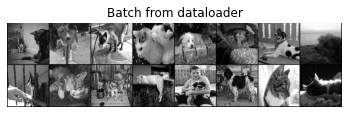

In [ ]:
def show_images(sample):
    #unpack the image/targets from our dataset class(def. above)
    image, target = sample
    #show those images - to make sure that processing so far has gone according to plan
    grid = utils.make_grid(image)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')
#for a sample in our dataloader
for sample in train_dataloader:
  #show the processed images
  plt.figure()
  show_images(sample)
  plt.axis('off')
  plt.ioff()
  plt.show()
  #break after 1 iter - no need/benefit to show any more
  break

# PyTorch Models
--------------------

In [ ]:
weights = torch.randn(16*128*128, 2)
weights.requires_grad_()
bias = torch.zeros(2, requires_grad=True)

## Class Based Approach

In [ ]:
class LinNet(nn.Module):
  def __init__(self):
      super(LinNet, self).__init__()
      self.fc1 = nn.Linear(16384, 500) # Input layer
      self.fc2 = nn.Linear(500, 500) # First hidden layer
      self.do1 = nn.Dropout(0.5) # Dropout layer (for regularization)
      self.fc3 = nn.Linear(500, 500) # Second hidden layer
      self.do2 = nn.Dropout(0.25) # Dropout layer (for regularization)
      #self.fc4 = nn.Linear(500, 500) # Third hidden layer
      self.out_labels = nn.Linear(500, 2) # Output layer
      self.out_boxes = nn.Linear(500,4)
  
  def forward(self, x):
      x = x.view(-1, self.num_flat_features(x)) # Flatten images
      x = F.relu(self.fc1(x)) # Pass through input layer and run activation function
      x = F.relu(self.fc2(x)) # Pass through hidden layer 1 and run activation function
      x = self.do1(x) # Pass through dropout layer
      x = F.relu(self.fc3(x)) # Pass through hidden layer 2 and run activation function
      x = self.do2(x) # Pass through second dropout layer
      output_labels = self.out_labels(x) # Output layer
      output_boxes = self.out_boxes(x)
      return output_labels, output_boxes

  def num_flat_features(self, x): #Flattening
      size = x.size()[1:] 
      num_features = 1
      for s in size:
         num_features *= s
      return num_features

### Network Layer Details

In [ ]:
#train 1 batch using the OOP network
# print layer information and print tensor shape for each layer
network = LinNet()
print(network)
print('-'*50)
print('Layer Tensor Shapes')
print(network.fc1.weight.shape)
print(network.fc2.weight.shape)
print(network.fc3.weight.shape)
print(network.out_labels.weight.shape)
print(network.out_boxes.weight.shape)


LinNet(
  (fc1): Linear(in_features=16384, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (do1): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=500, out_features=500, bias=True)
  (do2): Dropout(p=0.25, inplace=False)
  (out_labels): Linear(in_features=500, out_features=2, bias=True)
  (out_boxes): Linear(in_features=500, out_features=4, bias=True)
)
--------------------------------------------------
Layer Tensor Shapes
torch.Size([500, 16384])
torch.Size([500, 500])
torch.Size([500, 500])
torch.Size([2, 500])
torch.Size([4, 500])


In [ ]:
#print shape of weight and bias terms for each layer in NN
print('Shape of tensor for each layers weights and bias matrices:','\n')
for name, param in network.named_parameters():
  print(name, '\t', param.shape)

Shape of tensor for each layers weights and bias matrices: 

fc1.weight 	 torch.Size([500, 16384])
fc1.bias 	 torch.Size([500])
fc2.weight 	 torch.Size([500, 500])
fc2.bias 	 torch.Size([500])
fc3.weight 	 torch.Size([500, 500])
fc3.bias 	 torch.Size([500])
out_labels.weight 	 torch.Size([2, 500])
out_labels.bias 	 torch.Size([2])
out_boxes.weight 	 torch.Size([4, 500])
out_boxes.bias 	 torch.Size([4])


In [ ]:
torch.set_grad_enabled(False) #turn off gradients to freeze prop to run a single iteration manually

In [ ]:
#for each batch in the dataloader(loaded above)
batch = next(iter(train_dataloader))
#split out the image and the target(answers
images, targets = batch
#show the shape of 1 batch
print('Shape of a single batch:', images.shape)
#show the predictions of 1 batch
preds = network(images)
class_preds = preds[0]
bbox_preds = preds[1]
print('Shape of class predictions:', class_preds.shape)
print('Class predictions for single batch:', class_preds)
print('Shape of bounding box predictions:', bbox_preds.shape)
print('Bounding box predictions for single batch:', bbox_preds)

Shape of a single batch: torch.Size([16, 1, 128, 128])
Shape of class predictions: torch.Size([16, 2])
Class predictions for single batch: tensor([[ 0.0064,  0.0013],
        [ 0.0538, -0.0603],
        [ 0.0098,  0.0475],
        [-0.0009, -0.0259],
        [ 0.0348,  0.0048],
        [ 0.0288, -0.0489],
        [-0.0005,  0.0341],
        [ 0.0345, -0.0441],
        [ 0.0092, -0.0260],
        [ 0.0064, -0.0260],
        [ 0.0013,  0.0003],
        [-0.0080, -0.0102],
        [ 0.0444, -0.0065],
        [-0.0025, -0.0115],
        [ 0.0003, -0.0029],
        [ 0.0152,  0.0059]])
Shape of bounding box predictions: torch.Size([16, 4])
Bounding box predictions for single batch: tensor([[-0.0467,  0.0099,  0.0549, -0.0759],
        [-0.0926,  0.0452,  0.0356, -0.0840],
        [-0.0874,  0.0096, -0.0494, -0.0371],
        [-0.0781,  0.0172,  0.0107, -0.0623],
        [-0.0643,  0.0307,  0.0067, -0.0511],
        [-0.1318,  0.0401,  0.0481, -0.0236],
        [-0.0832,  0.0212, -0.0032, -0

In [ ]:
# define a function to get the total count of the correct class predictions

def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

print(class_preds.argmax(dim=1))
print(targets['labels'])

tensor([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1])


In [ ]:
torch.set_grad_enabled(True) # turn on gradient tracking again to do a back prop

In [ ]:
#set device type based on available hardware
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
torch.cuda.get_device_name(0)

if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")


Torch 1.7.0+cu101 CUDA 10.1
Device: cuda:0


In [ ]:
optimizer = optim.Adam(network.parameters(), lr=0.001)
criterion = nn.MSELoss()
optimizer.step() #update weights and bias

labels = targets['labels'].to(device) # Push target labels to device
boxes = targets['boxes'].to(device)
images = images.to(device)
network = network.to(device)
output_labels, output_boxes = network(images)
#output_boxes = model_boxes(images).to(device)
loss_classifier = F.cross_entropy(output_labels, labels) # Calculate loss function for classification
loss_boxes = criterion(output_boxes, boxes) 
loss = loss_classifier + loss_boxes
print("Updated loss after backpropagation", loss.item())

Updated loss after backpropagation 1.1881227493286133


### Training Loop for Class Based Approach

Start Epoch 
 --------------------------------------------------
Batch: 0 loss: 1.097517043352127 accuracy: 0.46875
Batch: 50 loss: 1.1292506456375122 accuracy: 0.53125
Batch: 100 loss: 1.0968376398086548 accuracy: 0.6875
Batch: 150 loss: 1.1089059710502625 accuracy: 0.5625
Batch: 200 loss: 1.1004424691200256 accuracy: 0.5625
Batch: 250 loss: 1.096636414527893 accuracy: 0.5
Batch: 300 loss: 1.1055527329444885 accuracy: 0.40625
Batch: 350 loss: 1.0431073606014252 accuracy: 0.75
Epoch: 0 Average accuracy: 0.5492343304843305 Average correct preds: 17.515669515669515 Average epoch loss: 1.1142570190450065
Batch: 0 loss: 1.125943809747696 accuracy: 0.5625
Batch: 25 loss: 1.1239923238754272 accuracy: 0.5
Batch: 50 loss: 1.1171000301837921 accuracy: 0.53125
Batch: 75 loss: 1.1072538495063782 accuracy: 0.53125
Epoch: 0 Average accuracy: 0.5546875 Average correct preds: 17.65909090909091 Average epoch loss: 1.1120012578639118
Start Epoch 
 --------------------------------------------------
Batc

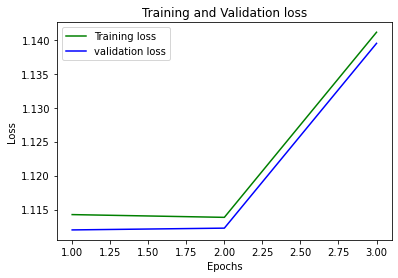

In [ ]:
optimizer = optim.Adam(model_labels.parameters(), lr=0.001) # Using Adam for better performance
criterion = nn.MSELoss() # Set MSE loss for boxes

#init data loaders for train/test
train_dataloader = DataLoader(dataset, batch_size=32, sampler=train_sampler, pin_memory=True)
test_dataloader = DataLoader(dataset, batch_size=32, sampler=test_sampler, pin_memory=True)
#iter 3 times
num_epochs = 3
loss_vals = []
accuracy_vals = []
loss_vals_test = []
accuracy_vals_test = []
for epoch in range(num_epochs):
  print('Start Epoch','\n','-'*50)
  # Initialize some counter values
  total_loss = 0
  total_correct = 0
  total_accuracy = 0
  model = LinNet()
  for idx, batch in enumerate(train_dataloader):
    images, targets = batch # Load images and targets
    labels = targets['labels'].to(device) # Push target labels to GPU
    boxes = targets['boxes'].to(device)
    images = images.to(device)
    model = model.to(device) # Push images to GPU
    outputs = model(images)
    loss_classifier = F.cross_entropy(outputs[0], labels) # Calculate loss function for classification
    loss_boxes = criterion(outputs[1], boxes) # Calculate loss function for regression
    loss = loss_classifier + loss_boxes # Sum
    optimizer.zero_grad() # Zero the gradient
    loss.backward() # Run backpropagation to calculate the gradient
    optimizer.step() # Run gradient update
    
    batch_loss = loss_classifier.item() + loss_boxes.item() # Get loss per batch as number instead of tensor
    total_loss += batch_loss
    batch_correct = get_num_correct(outputs[0], labels)
    total_correct += batch_correct
    accuracy = batch_correct / labels.size(0)
    total_accuracy += accuracy
    if idx%50 == 0:
      print('Batch:', idx, 'loss:', batch_loss, 'accuracy:', accuracy)
  
  avg_accuracy = total_accuracy/(idx+1)
  avg_loss = total_loss/(idx+1)
  accuracy_vals.append(avg_accuracy)
  loss_vals.append(avg_loss)

  print('Epoch:', epoch, 'Average accuracy:', avg_accuracy, 
        'Average correct preds:', total_correct/(idx+1), 'Average epoch loss:', avg_loss)
  
  # Run validation set
  with torch.no_grad():
    val_total_loss = 0
    val_total_correct = 0
    val_total_accuracy = 0

    for idx, batch in enumerate(test_dataloader):
      images, targets = batch
      val_labels = targets['labels'].to(device)
      val_boxes = targets['boxes'].to(device)
      images = images.to(device)
      model = model.to(device) # Push images to GPU
      outputs = model(images)
      loss_classifier = F.cross_entropy(outputs[0], val_labels) # Calculate loss function for classification
      loss_boxes = criterion(outputs[1], val_boxes) 
      loss = loss_classifier + loss_boxes
      #get loss
      batch_loss = loss_classifier.item() + loss_boxes.item()
      val_total_loss += batch_loss
      batch_correct = get_num_correct(outputs[0], val_labels)
      val_total_correct += batch_correct
      accuracy = batch_correct / val_labels.size(0)
      val_total_accuracy += accuracy
      if idx%25 == 0:
        print('Batch:', idx, 'loss:', batch_loss, 'accuracy:', accuracy)

    val_avg_accuracy = val_total_accuracy/(idx+1)
    val_avg_loss = val_total_loss/(idx+1)
    accuracy_vals_test.append(val_avg_accuracy)
    loss_vals_test.append(val_avg_loss)
  
    print('Epoch:', epoch, 'Average accuracy:', val_avg_accuracy, 
          'Average correct preds:', val_total_correct/(idx+1), 'Average epoch loss:', val_avg_loss)
  
epochs = range(1, num_epochs+1)
plt.plot(epochs, loss_vals, 'g', label='Training loss')
plt.plot(epochs, loss_vals_test, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

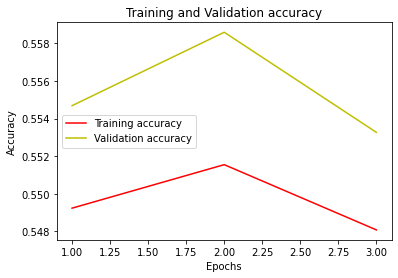

In [ ]:
epochs = range(1, num_epochs+1)
plt.plot(epochs, accuracy_vals, 'r', label='Training accuracy')
plt.plot(epochs, accuracy_vals_test, 'y', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Sequential Network Approach

In [ ]:
# Dense neural network without any regularization
import torch
import torch.nn as nn
import torch.nn.functional as F

model_labels = nn.Sequential(
                      nn.Flatten(start_dim=1), # Flatten images
                      nn.Linear(16384, 500), # Input layer
                      nn.ReLU(), # Activation function (Rectified Linear Unit)
                      nn.Linear(500, 500), # First hidden layer
                      nn.ReLU(),
                      nn.Linear(500, 500), 
                      nn.ReLU(),
                      nn.Linear(500, 500),
                      nn.ReLU(),
                      nn.Linear(500, 2) # Output layer
)

model_boxes = nn.Sequential(
                      nn.Flatten(start_dim=1), # Flatten images
                      nn.Linear(16384, 500), # Input layer
                      nn.ReLU(), # Activation function (Rectified Linear Unit)
                      nn.Linear(500, 500), # First hidden layer
                      nn.ReLU(),
                      nn.Linear(500, 500),
                      nn.ReLU(),
                      nn.Linear(500, 500),
                      nn.ReLU(),
                      nn.Linear(500, 4) # Output layer
)

In [ ]:
optimizer = optim.Adam(model_labels.parameters(), lr=0.001) # Using Adam for better performance
criterion = nn.MSELoss() # Set 

In [ ]:
if torch.cuda.is_available(): # Set device to GPU if available
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

### Training Loop for Sequential Architecture 

Start Epoch 
 --------------------------------------------------
Batch: 0 loss: 1.1486109495162964 accuracy: 0.53125
Batch: 50 loss: 1.1489271819591522 accuracy: 0.46875
Batch: 100 loss: 1.1989800333976746 accuracy: 0.46875
Batch: 150 loss: 1.1512570083141327 accuracy: 0.5
Batch: 200 loss: 1.1687305569648743 accuracy: 0.5
Batch: 250 loss: 1.139455407857895 accuracy: 0.5625
Batch: 300 loss: 1.1672885417938232 accuracy: 0.46875
Batch: 350 loss: 1.099180817604065 accuracy: 0.75
Epoch: 0 Average accuracy: 0.5476317663817664 Average correct preds: 17.464387464387464 Average epoch loss: 1.1464314625473784
Batch: 0 loss: 1.1431907415390015 accuracy: 0.625
Batch: 25 loss: 1.142123520374298 accuracy: 0.5
Batch: 50 loss: 1.1393329501152039 accuracy: 0.53125
Batch: 75 loss: 1.1283487677574158 accuracy: 0.625
Epoch: 0 Average accuracy: 0.5841619318181818 Average correct preds: 18.579545454545453 Average epoch loss: 1.1324160200628368
Start Epoch 
 --------------------------------------------------

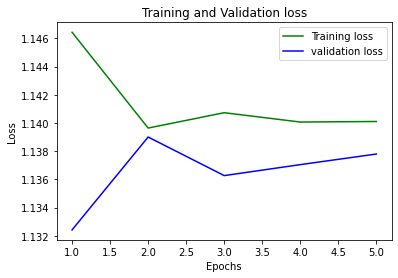

In [ ]:
import matplotlib.pyplot as plt

train_dataloader = DataLoader(dataset, batch_size=32, sampler=train_sampler, pin_memory=True)
test_dataloader = DataLoader(dataset, batch_size=32, sampler=test_sampler, pin_memory=True)

num_epochs = 5
loss_vals = []
accuracy_vals = []
loss_vals_test = []
accuracy_vals_test = []
for epoch in range(num_epochs):
  print('Start Epoch','\n','-'*50)

  total_loss = 0
  total_correct = 0
  total_accuracy = 0
  for idx, batch in enumerate(train_dataloader):
    images, targets = batch # Load images and targets
    labels = targets['labels'].to(device) # Push target labels to device
    boxes = targets['boxes'].to(device)
    output_labels = model_labels(images).to(device) # Push images to device
    output_boxes = model_boxes(images).to(device)
    loss_classifier = F.cross_entropy(output_labels, labels) # Calculate loss function for classification
    loss_boxes = criterion(output_boxes, boxes) 
    loss = loss_classifier + loss_boxes
    #loss.requires_grad = True
    optimizer.zero_grad() # Zero the gradient
    loss.backward() # Run backpropagation to calculate the gradient
    optimizer.step() # Run gradient update
    
    batch_loss = loss_classifier.item() + loss_boxes.item()
    total_loss += batch_loss
    batch_correct = get_num_correct(output_labels, labels)
    total_correct += batch_correct
    #total_correct += get_num_correct(preds, target['labels'])
    accuracy = batch_correct / labels.size(0)
    total_accuracy += accuracy
    if idx%50 == 0:
      #print('Batch:', idx, 'loss:', total_loss)
      print('Batch:', idx, 'loss:', batch_loss, 'accuracy:', accuracy)
  
  avg_accuracy = total_accuracy/(idx+1)
  avg_loss = total_loss/(idx+1)
  accuracy_vals.append(avg_accuracy)
  loss_vals.append(avg_loss)

  print('Epoch:', epoch, 'Average accuracy:', avg_accuracy, 
        'Average correct preds:', total_correct/(idx+1), 'Average epoch loss:', avg_loss)
  
  # Run validation set
  with torch.no_grad():
    val_total_loss = 0
    val_total_correct = 0
    val_total_accuracy = 0

    for idx, batch in enumerate(test_dataloader):
      images, targets = batch
      val_labels = targets['labels'].to(device)
      val_boxes = targets['boxes'].to(device)
      output_labels = model_labels(images).to(device) # Push images to GPU
      output_boxes = model_boxes(images).to(device)
      loss_classifier = F.cross_entropy(output_labels, val_labels) # Calculate loss function for classification
      loss_boxes = criterion(output_boxes, val_boxes) 
      loss = loss_classifier + loss_boxes
      #get loss
      batch_loss = loss_classifier.item() + loss_boxes.item()
      val_total_loss += batch_loss
      batch_correct = get_num_correct(output_labels, val_labels)
      val_total_correct += batch_correct
      accuracy = batch_correct / val_labels.size(0)
      val_total_accuracy += accuracy
      if idx%25 == 0:
        print('Batch:', idx, 'loss:', batch_loss, 'accuracy:', accuracy)

    val_avg_accuracy = val_total_accuracy/(idx+1)
    val_avg_loss = val_total_loss/(idx+1)
    accuracy_vals_test.append(val_avg_accuracy)
    loss_vals_test.append(val_avg_loss)
  
    print('Epoch:', epoch, 'Average accuracy:', val_avg_accuracy, 
          'Average correct preds:', val_total_correct/(idx+1), 'Average epoch loss:', val_avg_loss)
  
epochs = range(1, num_epochs+1)
plt.plot(epochs, loss_vals, 'g', label='Training loss')
plt.plot(epochs, loss_vals_test, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

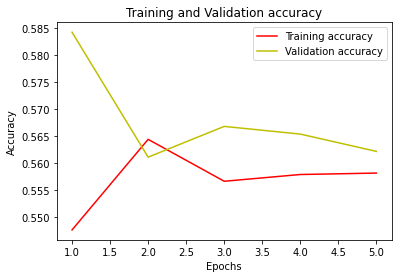

In [ ]:
epochs = range(1, num_epochs+1)
plt.plot(epochs, accuracy_vals, 'r', label='Training accuracy')
plt.plot(epochs, accuracy_vals_test, 'y', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Dense neural network with dropout layers

import torch
import torch.nn as nn
import torch.nn.functional as F

model_labels = nn.Sequential(
                      nn.Flatten(start_dim=1), # Flatten images
                      nn.Linear(16384, 500), # Input layer
                      nn.ReLU(), # Activation function (Rectified Linear Unit)
                      nn.Linear(500, 500), # First hidden layer
                      nn.Dropout(0.5), # Dropout layer (for regularization)
                      nn.ReLU(),
                      nn.Linear(500, 500),
                      nn.Dropout(0.25), # Dropout layer (smaller probability)
                      nn.ReLU(),
                      nn.Linear(500, 500),
                      nn.ReLU(),
                      nn.Linear(500, 2) # Output layer
)

model_boxes = nn.Sequential(
                      nn.Flatten(start_dim=1), # Flatten images
                      nn.Linear(16384, 500), # Input layer
                      nn.ReLU(), # Activation function (Rectified Linear Unit)
                      nn.Linear(500, 500), # First hidden layer
                      nn.Dropout(0.5), # Dropout layer (for regularization)
                      nn.ReLU(), # Activation function
                      nn.Linear(500, 500),
                      nn.Dropout(0.25), # Dropout layer (smaller probability)
                      nn.ReLU(),
                      nn.Linear(500, 500),
                      nn.ReLU(),
                      nn.Linear(500, 4) # Output layer
)

In [ ]:
optimizer = optim.Adam(model_labels.parameters(), lr=0.001) # Using Adam for better performance
criterion = nn.MSELoss() # Set 

In [ ]:
if torch.cuda.is_available(): # Set device to GPU if available
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")


### Training Loop for Sequential Architecture with Regularization

Start Epoch 
 --------------------------------------------------
Batch: 0 loss: 1.1243801712989807 accuracy: 0.5625
Batch: 50 loss: 1.1367712020874023 accuracy: 0.5625
Batch: 100 loss: 1.1232600808143616 accuracy: 0.5
Batch: 150 loss: 1.1060666739940643 accuracy: 0.625
Batch: 200 loss: 1.1222960948944092 accuracy: 0.59375
Batch: 250 loss: 1.1228951215744019 accuracy: 0.53125
Batch: 300 loss: 1.1156576871871948 accuracy: 0.5
Batch: 350 loss: 1.1330036520957947 accuracy: 0.5
Epoch: 0 Average accuracy: 0.5539529914529915 Average correct preds: 17.686609686609685 Average epoch loss: 1.1207163724464568
Batch: 0 loss: 1.1060558557510376 accuracy: 0.65625
Batch: 25 loss: 1.1459832191467285 accuracy: 0.25
Batch: 50 loss: 1.1296564638614655 accuracy: 0.59375
Batch: 75 loss: 1.1291791498661041 accuracy: 0.53125
Epoch: 0 Average accuracy: 0.5610795454545454 Average correct preds: 17.863636363636363 Average epoch loss: 1.1186335432258518
Start Epoch 
 ----------------------------------------------

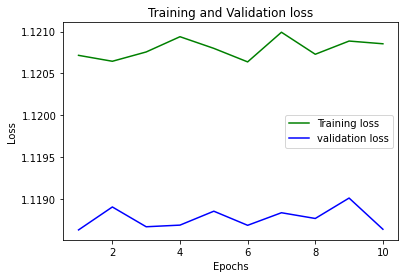

In [ ]:
import matplotlib.pyplot as plt

train_dataloader = DataLoader(dataset, batch_size=32, sampler=train_sampler, pin_memory=True)
test_dataloader = DataLoader(dataset, batch_size=32, sampler=test_sampler, pin_memory=True)

num_epochs = 10
loss_vals = []
accuracy_vals = []
loss_vals_test = []
accuracy_vals_test = []
for epoch in range(num_epochs):
  print('Start Epoch','\n','-'*50)

  total_loss = 0
  total_correct = 0
  total_accuracy = 0
  for idx, batch in enumerate(train_dataloader):
    images, targets = batch # Load images and targets
    labels = targets['labels'].to(device) # Push target labels to device
    boxes = targets['boxes'].to(device)
    output_labels = model_labels(images).to(device) # Push images to device
    output_boxes = model_boxes(images).to(device)
    loss_classifier = F.cross_entropy(output_labels, labels) # Calculate loss function for classification
    loss_boxes = criterion(output_boxes, boxes) 
    loss = loss_classifier + loss_boxes
    loss.requires_grad = True
    optimizer.zero_grad() # Zero the gradient
    loss.backward() # Run backpropagation to calculate the gradient
    optimizer.step() # Run gradient update
    
    batch_loss = loss_classifier.item() + loss_boxes.item()
    total_loss += batch_loss
    batch_correct = get_num_correct(output_labels, labels)
    total_correct += batch_correct
    #total_correct += get_num_correct(preds, target['labels'])
    accuracy = batch_correct / labels.size(0)
    total_accuracy += accuracy
    if idx%50 == 0:
      #print('Batch:', idx, 'loss:', total_loss)
      print('Batch:', idx, 'loss:', batch_loss, 'accuracy:', accuracy)
  
  avg_accuracy = total_accuracy/(idx+1)
  avg_loss = total_loss/(idx+1)
  accuracy_vals.append(avg_accuracy)
  loss_vals.append(avg_loss)

  print('Epoch:', epoch, 'Average accuracy:', avg_accuracy, 
        'Average correct preds:', total_correct/(idx+1), 'Average epoch loss:', avg_loss)
  
  # Run validation set
  with torch.no_grad():
    val_total_loss = 0
    val_total_correct = 0
    val_total_accuracy = 0

    for idx, batch in enumerate(test_dataloader):
      images, targets = batch
      val_labels = targets['labels'].to(device)
      val_boxes = targets['boxes'].to(device)
      output_labels = model_labels(images).to(device) # Push images to GPU
      output_boxes = model_boxes(images).to(device)
      loss_classifier = F.cross_entropy(output_labels, val_labels) # Calculate loss function for classification
      loss_boxes = criterion(output_boxes, val_boxes) 
      loss = loss_classifier + loss_boxes
      #get loss
      batch_loss = loss_classifier.item() + loss_boxes.item()
      val_total_loss += batch_loss
      batch_correct = get_num_correct(output_labels, val_labels)
      val_total_correct += batch_correct
      accuracy = batch_correct / val_labels.size(0)
      val_total_accuracy += accuracy
      if idx%25 == 0:
        print('Batch:', idx, 'loss:', batch_loss, 'accuracy:', accuracy)

    val_avg_accuracy = val_total_accuracy/(idx+1)
    val_avg_loss = val_total_loss/(idx+1)
    accuracy_vals_test.append(val_avg_accuracy)
    loss_vals_test.append(val_avg_loss)
  
    print('Epoch:', epoch, 'Average accuracy:', val_avg_accuracy, 
          'Average correct preds:', val_total_correct/(idx+1), 'Average epoch loss:', val_avg_loss)
  
epochs = range(1, num_epochs+1)
plt.plot(epochs, loss_vals, 'g', label='Training loss')
plt.plot(epochs, loss_vals_test, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

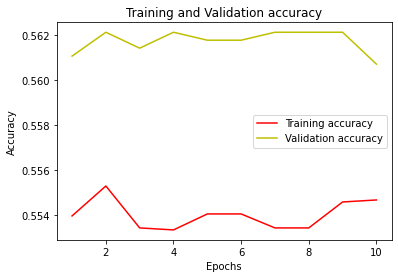

In [ ]:
epochs = range(1, num_epochs+1)
plt.plot(epochs, accuracy_vals, 'r', label='Training accuracy')
plt.plot(epochs, accuracy_vals_test, 'y', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## ResNet Approach

For this approach we are reloading the data into the dataframe from scratch to reset the variables. The data is then explored to see the full size again and parsed back down the 15001 unique images that have a bounding box area larger than .4.

In [ ]:
from PIL import Image

import torch
import torch.nn as nn

from torchvision import transforms
import torchvision.models as models

In [ ]:
import pandas as pd

#read csv with meta-data into memory
df = pd.read_csv('/content/drive/MyDrive/AML Final Project/cat_dog_boxes.csv')
datadir = "/content/drive/MyDrive/AML Final Project/cat_dog/"

df.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000b9fcba019d36,xclick,/m/0bt9lr,1,0.165000,0.903750,0.268333,0.998333,1,1,0,0,0,0.636250,0.90375,0.748750,0.165000,0.268333,0.506667,0.998333,0.661667
1,0000cb13febe0138,xclick,/m/0bt9lr,1,0.000000,0.651875,0.000000,0.999062,1,1,0,0,0,0.312500,0.00000,0.317500,0.651875,0.000000,0.410882,0.999062,0.999062
2,000256419f7c57d8,xclick,/m/0bt9lr,1,0.190625,0.301250,0.530000,0.650000,1,0,0,0,0,0.290625,0.30125,0.273750,0.190625,0.530000,0.549167,0.650000,0.603333
3,000256419f7c57d8,xclick,/m/0bt9lr,1,0.450000,0.562500,0.485833,0.598333,1,0,0,0,0,0.541875,0.56250,0.450000,0.500625,0.485833,0.491667,0.543333,0.598333
4,000256419f7c57d8,xclick,/m/0bt9lr,1,0.558750,0.615625,0.515000,0.592500,1,0,0,0,0,0.576875,0.55875,0.615625,0.574375,0.515000,0.550000,0.584167,0.592500


In [ ]:
df_labels_bb = df.drop(['Source', 
                        'Confidence', 
                        'XClick1X', 
                        'XClick2X', 
                        'XClick3X',
                        'XClick4X',
                        'XClick1Y',
                        'XClick2Y',
                        'XClick3Y',
                        'XClick4Y'], axis=1)

df_labels_bb.head()

,ImageID,LabelName,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,0000b9fcba019d36,/m/0bt9lr,0.165000,0.903750,0.268333,0.998333,1,1,0,0,0
1,0000cb13febe0138,/m/0bt9lr,0.000000,0.651875,0.000000,0.999062,1,1,0,0,0
2,000256419f7c57d8,/m/0bt9lr,0.190625,0.301250,0.530000,0.650000,1,0,0,0,0
3,000256419f7c57d8,/m/0bt9lr,0.450000,0.562500,0.485833,0.598333,1,0,0,0,0
4,000256419f7c57d8,/m/0bt9lr,0.558750,0.615625,0.515000,0.592500,1,0,0,0,0


In [ ]:
import numpy as np

# assign dog and cat labels
df_labels_bb['CoD'] = np.where(df_labels_bb['LabelName'] == '/m/0bt9lr', 'dog', 'cat')

df_proper_labels_bb = df_labels_bb.drop(['LabelName'],axis=1)

#calculate area of bounding box
df_proper_labels_bb['area'] = ((df_proper_labels_bb['XMax']-df_proper_labels_bb['XMin']) * (df_proper_labels_bb['YMax']-df_proper_labels_bb['YMin']))

df_proper_labels_bb.head()

,ImageID,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,CoD,area
0,0000b9fcba019d36,0.165000,0.903750,0.268333,0.998333,1,1,0,0,0,dog,0.539288
1,0000cb13febe0138,0.000000,0.651875,0.000000,0.999062,1,1,0,0,0,dog,0.651264
2,000256419f7c57d8,0.190625,0.301250,0.530000,0.650000,1,0,0,0,0,dog,0.013275
3,000256419f7c57d8,0.450000,0.562500,0.485833,0.598333,1,0,0,0,0,dog,0.012656
4,000256419f7c57d8,0.558750,0.615625,0.515000,0.592500,1,0,0,0,0,dog,0.004408


            ImageID      XMin      XMax  ...  IsInside  CoD      area
0  0000b9fcba019d36  0.165000  0.903750  ...         0  dog  0.539288
1  0000cb13febe0138  0.000000  0.651875  ...         0  dog  0.651264
2  0005a9520eb22c19  0.094167  0.611667  ...         0  dog  0.488059
3  0006303f02219b07  0.000000  0.999219  ...         0  dog  0.998044
4  00064d23bf997652  0.240938  0.906183  ...         0  dog  0.461870

[5 rows x 12 columns]
Dog Images: 8351
Cat Images: 6985
Occluded: 7435
Truncated: 11343
Groups: 210
Depictions: 679
Inside: 12
Size of sample: 15336
(15001,)


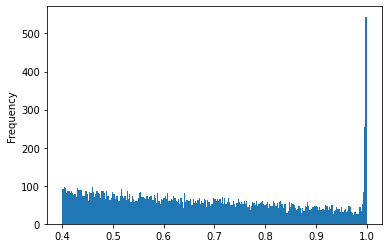

In [ ]:
# remove any images with a bounding box area less than .4
df_filtered = df_proper_labels_bb[df_proper_labels_bb['area']>0.4]
df_filtered.reset_index(inplace=True,drop=True)

print(df_filtered.head())


# get exploratory information about remaining counts of each type of image
dog_row_count = len(df_filtered.loc[df_filtered['CoD'] == 'dog'])
cat_row_count = len(df_filtered.loc[df_filtered['CoD'] == 'cat'])
num_occluded = df_filtered['IsOccluded'].sum()
num_truncated = df_filtered['IsTruncated'].sum()
num_group = df_filtered['IsGroupOf'].sum()
num_depiction = df_filtered['IsDepiction'].sum()
num_inside = df_filtered['IsInside'].sum()

#display counts
print('Dog Images:', dog_row_count)
print('Cat Images:', cat_row_count)
print('Occluded:', num_occluded)
print('Truncated:', num_truncated)
print('Groups:', num_group)
print('Depictions:', num_depiction)
print('Inside:', num_inside)


#Print unique items
print('Size of sample:', len(df_filtered))
print(df_filtered.ImageID.unique().shape)
#display the frequency of bounding box size as a histogram
areas_hist = df_filtered['area'].plot.hist(bins = 250)


In [ ]:
#PyTorch expects a dataset class to call it's methods
##some of the finer details can be found here <https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html>
class CatDogDataset(Dataset):
    def __init__(self, df, root_dir, transform):
        #root dir is the main location of image files
        self.root_dir = root_dir
        #csv with metadata about images
        self.df = df
        #torch pipeline to transform images to tensors
        self.transform = transform

    def __len__(self):
        #torch requires a __len__() method
        return len(self.df)

    def __getitem__(self, idx):
      # print(idx)
      # print(self.df.head())
      # print(self.df.ImageID[idx])
      # __getitem__ is where the bulk of the work in the this class happens
      # first hardcode what the dog label is - we change it to something a little more torch friednly later
      # dog_label = '/m/0bt9lr'
      #given an index position read that image into memory
      img_name = os.path.join(self.root_dir,self.df.ImageID[idx]+'.jpg')
      #saving it as a PIL object
      image = Image.open(img_name).convert('RGB')
      #if something was passed to transform run our image through that pipline
      ##changing it from a PIL object into a tensor for PyTorch
      if self.transform:
        image = self.transform(image)
      #change the cat/dog labels into int64 and move them to a tensor for later torch methods
      if self.df.CoD[idx] == 'dog':
        label = torch.as_tensor(1, dtype = torch.int64)
      #at first cat was 2 - but pytorch treats a class of 0 as background?, and we don't want cats treated as background
      else:
        label = torch.as_tensor(0, dtype = torch.int64)
      #use idx as unique id for an image(needs to be numeric to be a tensor)
      image_id = torch.as_tensor(idx, dtype = torch.int64)
      # create features for the center of the bounding box and height and width 
      # this will later be used to calculate the area of the predicted bounding box 
      xc = 0.5*(self.df.XMin[idx]+self.df.XMax[idx])
      yc = 0.5*(self.df.YMin[idx]+self.df.YMax[idx])
      w = self.df.XMax[idx] - self.df.XMin[idx]
      h = self.df.YMax[idx] - self.df.YMin[idx]
      #not sure what iscrowd() is meant to do - but listed as required in the docs
      iscrowd = torch.zeros((1,), dtype=torch.float32)
      #finally take everything that was parsed out above and save it to a dictionary called targets(as per the documentation)
      target = {}
      target['box_info'] = torch.tensor([xc,yc,w,h], dtype=torch.float32)
      target['labels'] = label
      target['image_id'] = image_id
      target['iscrowd'] = iscrowd
      #returning the image(as a tensor) and the target(dictionary of tensors)
      return image, target

In [ ]:
# creator a series of transformers for data that will be read into the Pytorch dataset we created
transform = transforms.Compose([
    transforms.Resize(256), #resize image down to 256,256
    transforms.CenterCrop(224), # crop image from the center to 224,224
    transforms.ToTensor(), # turn the returned item from the dataset to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #normalize the data to this distribution
])

In [ ]:
from sklearn.model_selection import train_test_split

# create test, train, and validation sets from the dataset we filtered down above and stratify on the CoD column to account for imbalance in data
df_train_temp, df_test = train_test_split(df_filtered, test_size=.1, 
                                          stratify=df_filtered.CoD, random_state=42)
df_train, df_val = train_test_split(df_train_temp, test_size=0.2, 
                                    random_state=42)

In [ ]:
print('Train set shape:', df_train.shape)
print('Test set shape:', df_test.shape)
print('Validation set shape:', df_val.shape)

df_train.reset_index(inplace=True,drop=True)
df_test.reset_index(inplace=True,drop=True)
df_val.reset_index(inplace=True,drop=True)

Train set shape: (11041, 12)
Test set shape: (1534, 12)
Validation set shape: (2761, 12)


In [ ]:
root_dir = '/content/drive/MyDrive/AML Final Project/cat_dog'

# Create Train, Test, Validation pytorch datasets
train_ds = CatDogDataset(df_train, root_dir=root_dir, transform=transform)
test_ds = CatDogDataset(df_test, root_dir=root_dir, transform=transform)
val_ds = CatDogDataset(df_val, root_dir=root_dir, transform=transform)

In [ ]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

# Show example item in training set
train_ds.__getitem__(1)


11041
1534
2761


(tensor([[[ 0.7419,  0.6049,  0.4337,  ..., -1.1247, -1.3302, -1.3815],
          [ 0.5193,  0.4851,  0.3994,  ..., -0.7479, -1.1760, -1.3473],
          [ 0.3481,  0.3823,  0.4166,  ..., -0.4226, -0.8164, -1.1932],
          ...,
          [-1.1760, -1.1247, -0.7822,  ...,  0.1254,  0.1939,  0.1254],
          [-0.8164, -0.7650, -0.7479,  ...,  0.0912,  0.2453,  0.2111],
          [-0.5424, -0.5596, -0.6794,  ...,  0.0741,  0.2282,  0.2624]],
 
         [[ 0.8179,  0.6254,  0.4503,  ..., -0.9153, -1.1604, -1.1954],
          [ 0.5728,  0.4853,  0.3803,  ..., -0.4776, -1.0028, -1.1078],
          [ 0.4153,  0.4153,  0.4678,  ..., -0.0574, -0.5301, -0.9328],
          ...,
          [-1.0203, -0.9853, -0.6877,  ...,  0.3452,  0.4503,  0.3102],
          [-0.6001, -0.6176, -0.6176,  ...,  0.3102,  0.5028,  0.4503],
          [-0.4776, -0.5301, -0.4951,  ...,  0.3277,  0.4328,  0.4503]],
 
         [[ 0.9319,  0.7228,  0.5311,  ..., -0.9504, -1.0550, -1.0724],
          [ 0.6531,  0.5659,

In [ ]:
Create a sample dataloader to show what a single batch of images looks like

In [ ]:
dataloader = DataLoader(train_ds, batch_size=24, 
                        shuffle=True, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


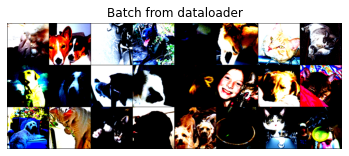

In [ ]:
def show_images(sample):
    #unpack the image/targets from our dataset class(def. above)
    image, target = sample
    #show those images - to make sure that processing so far has gone according to plan
    grid = utils.make_grid(image)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')

# for idx, (data, image) in enumerate(train_ds):
#     print(idx)
for sample in dataloader:
  #show the processed images
  plt.figure()
  show_images(sample)
  plt.axis('off')
  plt.ioff()
  plt.show()
  #break after 1 iter - no need/benefit to show any more
  break

In [ ]:
# load the pretrained resnet50
model = models.resnet50(pretrained=True)

In [ ]:
input_size = 2048
num_classes = 2
batch_size = 100
epochs = int(len(train_ds)/batch_size*20)
lr = 0.001
print(epochs)

110


### Hybrid Model Transfer Learning Using Resnet 

In [ ]:
# def two functions to calculate the intersection over union which is an evaluation metric
# of the bounding box prediction.

def calc_iou(bbox_true,bbox_pred,matrix_size=100):
  # bbox_true, bbox_pred : n x 4 numpy arrays of xc,yc,w,h

  nb = bbox_true.shape[0]
  iou = np.zeros(nb)
  for i in range(nb):
    print
    x0t,x1t,y0t,y1t = bbox_center_to_corner(bbox_true[i]) # calculate the area of the true bounding box
    x0p,x1p,y0p,y1p = bbox_center_to_corner(bbox_pred[i]) # calculate the area of the predicted bounding box

    # determine the points at which the predicted and true bounding box overlap
    x0i,x1i = max(x0t,x0p),min(x1t,x1p) 
    y0i,y1i = max(y0t,y0p),min(y1t,y1p)

    # calculate the area of the intersecting box
    interArea = max(0, x1i - x0i + 1) * max(0, y1i - y0i + 1)

    # calculate the area of the predicted and true boxes
    boxtrueArea = (x1t - x0t + 1) * (y1t - y0t + 1)
    boxpredArea = (x1p - x0p + 1) * (y1p - y0p + 1)

    iou_val = interArea/((boxtrueArea+boxpredArea)-interArea)
    iou[i] = iou_val
  return iou

# calculate the dimensions of the box from the center and width metrics
def bbox_center_to_corner(bbox):
  xc, yc, w, h = ( bbox[i] for i in range(4) )
  return xc - 0.5*w, xc + 0.5*w, yc - 0.5*h, yc + 0.5*h 

In [ ]:
# Create a class of for the hybrid resnet50 model with custom top layer for each task
class ResNetModel(nn.Module):
  def __init__(self):
      super(ResNetModel, self).__init__()
      self.bottom = model
      self.classifier = nn.Sequential(
          nn.Linear(1000, 2)
      )
      self.box = nn.Sequential(
          nn.Linear(1000, 4)
      )
  
  def forward(self, x):
      x = self.bottom(x) #pass x through the pretrained model
      x = F.relu(x) # activation function 
      x = x.view(x.shape[0],-1) #flatten the output
      output_labels = self.classifier(x) # Output layer
      output_boxes = self.box(x)
      return output_labels, output_boxes

In [ ]:
from torchsummary import summary


model_rn = ResNetModel()
model_rn.to(device)
summary(model_rn,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# create loss objects for building the combined loss function of the bounding box and classifer task
label_loss = nn.CrossEntropyLoss()
box_loss = nn.MSELoss()
box_reg_loss = nn.L1Loss(reduction='sum')

# identify which layers in this model have the parameters unfrozen and can be updated by the optimzer
# In this model it is only the linear layers
parameters = filter(lambda x: x.requires_grad, model.parameters())
optimizer = optim.Adam(parameters, lr=lr)

Start Epoch 
 --------------------------------------------------
Batch: 0 loss: 1.5888689756393433 accuracy: 0.33
Batch: 50 loss: 0.2995599713176489 accuracy: 0.84
Batch: 100 loss: 0.23780285380780697 accuracy: 0.91
Epoch: 0 Average accuracy: 0.8427272727272731 Average correct preds: 84.27272727272727 Average epoch loss: 0.43978463207286866
Batch: 0 loss: 2.309867551550269 accuracy: 0.86
Batch: 25 loss: 1.8313802741467953 accuracy: 0.95
Epoch: 0 Average accuracy: 0.8866666666666665 Average correct preds: 88.66666666666667 Average epoch loss: 2.058549239679619
Start Epoch 
 --------------------------------------------------
Batch: 0 loss: 0.2137409746646881 accuracy: 0.93
Batch: 50 loss: 0.24271382205188274 accuracy: 0.86
Batch: 100 loss: 0.14797222148627043 accuracy: 0.94
Epoch: 1 Average accuracy: 0.8993636363636359 Average correct preds: 89.93636363636364 Average epoch loss: 0.24725447198037398
Batch: 0 loss: 2.477616550400853 accuracy: 0.89
Batch: 25 loss: 1.9033039547502995 accurac

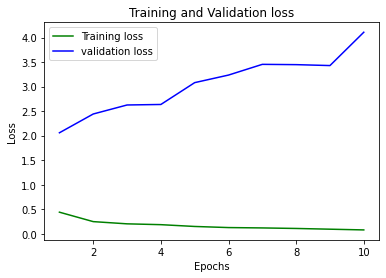

In [ ]:
#Load validation and training set
val_dataloader = DataLoader(val_ds,batch_size=batch_size, 
                        shuffle=True, num_workers=0, drop_last=True)
train_dataloader = DataLoader(train_ds,batch_size=batch_size, 
                        shuffle=True, num_workers=0, drop_last=True)
loss_vals = []
accuracy_vals = []
loss_vals_test = []
accuracy_vals_test = []
iou = []
val_iou = []
for epoch in range(epochs):
  print('Start Epoch','\n','-'*50)
  # Initialize some counter values
  total_loss = 0
  total_correct = 0
  total_accuracy = 0
  totla_iou=0
  for idx, batch in enumerate(train_dataloader):
    images, targets = batch # Load images and targets
    labels = targets['labels'].to(device) # Push target labels to GPU
    boxes = targets['box_info'].to(device)
    images = images.to(device)
    model_rn.to(device) # Push images to GPU
    outputs = model_rn(images)
    loss_classifier = label_loss(outputs[0], labels) # Calculate loss function for classification
    loss_boxes = box_loss(outputs[1], boxes) # Calculate loss function for regression
    # print(type(loss_boxes), type(loss_classifier))
    loss = loss_classifier + loss_boxes # Sum
    optimizer.zero_grad() # Zero the gradient
    loss.backward() # Run backpropagation to calculate the gradient
    optimizer.step() # Run gradient update
    
    batch_loss = loss_classifier.item() + loss_boxes.item() # Get loss per batch as number instead of tensor
    total_loss += batch_loss
    batch_correct = get_num_correct(outputs[0], labels) # get number of correct predictions in the batch
    total_correct += batch_correct
    accuracy = batch_correct / labels.size(0) #accuracy for classified task in batch
    total_accuracy += accuracy
    iou_avg_batch = calc_iou(boxes,outputs[1]).mean() #calculate average intersection over union for batch
    total_iou += iou_avg_batch 
    print('Batch:', idx, 'loss:', batch_loss, 'accuracy:', accuracy, 'iou:', iou)
  
  avg_accuracy = total_accuracy/(idx+1)
  avg_loss = total_loss/(idx+1)
  accuracy_vals.append(avg_accuracy)
  loss_vals.append(avg_loss)
  iou.append(total_iou/len(train_dataloader))

  print('Epoch:', epoch, 'Average accuracy:', avg_accuracy, 
        'Average correct preds:', total_correct/(idx+1), 'Average epoch loss:', avg_loss)
  
  # Run validation set
  with torch.no_grad():
    val_total_loss = 0
    val_total_correct = 0
    val_total_accuracy = 0
    val_iou = 0
    for idx, batch in enumerate(val_dataloader):
      images, targets = batch
      val_labels = targets['labels'].to(device)
      val_boxes = targets['box_info'].to(device)
      images = images.to(device)
      model = model_rn.to(device) # Push images to GPU
      outputs = model(images)
      loss_classifier = label_loss(outputs[0], labels) # Calculate loss function for classification
      loss_boxes = box_loss(outputs[1], boxes)
      loss = loss_classifier + loss_boxes
      #get loss
      batch_loss = loss_classifier.item() + loss_boxes.item()
      val_total_loss += batch_loss
      batch_correct = get_num_correct(outputs[0], val_labels)
      val_total_correct += batch_correct
      accuracy = batch_correct / val_labels.size(0)
      val_total_accuracy += accuracy
      val_iou_avg_batch = calc_iou(boxes,outputs[1]).mean()
      val_total_iou += iou_avg_batch
      if idx%25 == 0:
        print('Batch:', idx, 'loss:', batch_loss, 'accuracy:', accuracy, 'iou:' val_iou_avg_batch)

    val_avg_accuracy = val_total_accuracy/(idx+1)
    val_avg_loss = val_total_loss/(idx+1)
    accuracy_vals_test.append(val_avg_accuracy)
    loss_vals_test.append(val_avg_loss)
    val_iou.append(val_total_iou/len(val_dataloader))
  
    print('Epoch:', epoch, 'Average accuracy:', val_avg_accuracy, 
          'Average correct preds:', val_total_correct/(idx+1), 'Average epoch loss:', val_avg_loss)
  
epochs = range(1, epochs+1)
plt.plot(epochs, loss_vals, 'g', label='Training loss')
plt.plot(epochs, loss_vals_test, 'b', label='validation loss')
plt.plot(epochs, val_iou, 'g', label='validation iou')
plt.plot(epochs, val_iou, 'g', label='Training iou')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_loader = DataLoader(test_ds,batch_size=batch_size, 
                        shuffle=True, num_workers=0, drop_last=True)


model.eval()
regression_loss = 0
num_correct = 0

for idx, batch in enumerate(test_loader):
  x, y = batch
  y_bb = y['box_info']
  y_label = y['labels']

  x, y_bb, y_label = x.to(device), y_bb.to(device), y_class.to(device)
  model_rn.to(device)
  outputs = model_rn(x)

  bb_loss = box_reg_loss(outputs[1], y_bb)/4.0
  class_loss = label_loss(outputs[0], y_label)

  regression_loss += bb_loss.item()

  total_loss = bb_loss+class_loss

  batch_correct = get_num_correct(outputs[0], y_label)
  test_total_correct += batch_correct
  accuracy = batch_correct / test_labels.size(0)
  test_total_accuracy += accuracy

  print(f'Test Bounding Box Loss: {bb_loss}, Test Classifier Accuracy: {accuracy}, Total Loss: {total_loss}')

total_accuracy = test_total_accuracy/len(test_loader)
total_reg_loss = regression_loss/len(test_loader)
print(f'Total Bounding Box Loss: {total_reg_loss}, Total Classifier Accuracy:{total_accuracy}')



    

AttributeError: ignored

### FCN Model Transfer Learning Using ResNet

In [ ]:
from torchsummary import summary

# Create a FCNN model that replaces the last layer in resnet with a convolutional layer with a 1 by 1 kernal size
class FCNModel(nn.Module):
  def __init__(self):
      super(FCNModel, self).__init__()
      layers = list(model.children())[:-2]
      self.bottom = nn.Sequential(*layers[:])
      self.labels = nn.Sequential(
          nn.Conv2d(2048,2,(1,1))
      )
      self.box = nn.Sequential(
          nn.Conv2d(2048,4,(1,1))
      )
  
  def forward(self, x):
      x = self.bottom(x)
      print(x.size())
      # x = F.relu(x) 
      # x = x.view(x.shape[0],-1)
      output_labels = self.labels(x)
      output_boxes = self.box(x)
      return output_labels


In [ ]:
model_fcn = FCNModel()
model_fcn.to('cuda:0')

for name, param in model_fcn.named_parameters():
  if param.requires_grad and 'top' in name:
    print(name)
  else:
    param.requires_grad = False
# print(model_fcn)
# summary(model_fcn,(3,224,224))

top.0.weight
top.0.bias


In [ ]:
summary(model_fcn,(3,224,224))

torch.Size([2, 2048, 7, 7])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      Batch

In [ ]:
val_dataloader = DataLoader(val_ds,batch_size=batch_size, 
                        shuffle=True, num_workers=0, drop_last=True)
train_dataloader = DataLoader(train_ds,batch_size=batch_size, 
                        shuffle=True, num_workers=0, drop_last=True)
loss_vals = []
accuracy_vals = []
loss_vals_test = []
accuracy_vals_test = []
iou = []
val_iou = []
for epoch in range(epochs):
  print('Start Epoch','\n','-'*50)
  # Initialize some counter values
  total_loss = 0
  total_correct = 0
  total_accuracy = 0
  totla_iou=0
  for idx, batch in enumerate(train_dataloader):
    images, targets = batch # Load images and targets
    labels = targets['labels'].to(device) # Push target labels to GPU
    boxes = targets['box_info'].to(device)
    images = images.to(device)
    model_fcn.to(device) # Push images to GPU
    outputs = model_rn(images)
    loss_classifier = label_loss(outputs[0], labels) # Calculate loss function for classification
    loss_boxes = box_loss(outputs[1], boxes) # Calculate loss function for regression
    # print(type(loss_boxes), type(loss_classifier))
    loss = loss_classifier + loss_boxes # Sum
    optimizer.zero_grad() # Zero the gradient
    loss.backward() # Run backpropagation to calculate the gradient
    optimizer.step() # Run gradient update
    
    batch_loss = loss_classifier.item() + loss_boxes.item() # Get loss per batch as number instead of tensor
    total_loss += batch_loss
    batch_correct = get_num_correct(outputs[0], labels)
    total_correct += batch_correct
    accuracy = batch_correct / labels.size(0)
    total_accuracy += accuracy
    iou_avg_batch = calc_iou(boxes,outputs[1]).mean()
    total_iou += iou_avg_batch
    print('Batch:', idx, 'loss:', batch_loss, 'accuracy:', accuracy, 'iou:', iou)
  
  avg_accuracy = total_accuracy/(idx+1)
  avg_loss = total_loss/(idx+1)
  accuracy_vals.append(avg_accuracy)
  loss_vals.append(avg_loss)
  iou.append(total_iou/len(train_dataloader))

  print('Epoch:', epoch, 'Average accuracy:', avg_accuracy, 
        'Average correct preds:', total_correct/(idx+1), 'Average epoch loss:', avg_loss)
  
  # Run validation set
  with torch.no_grad():
    val_total_loss = 0
    val_total_correct = 0
    val_total_accuracy = 0
    val_iou = 0
    for idx, batch in enumerate(val_dataloader):
      images, targets = batch
      val_labels = targets['labels'].to(device)
      val_boxes = targets['box_info'].to(device)
      images = images.to(device)
      model = model_fcn.to(device) # Push images to GPU
      outputs = model(images)
      loss_classifier = label_loss(outputs[0], labels) # Calculate loss function for classification
      loss_boxes = box_loss(outputs[1], boxes)
      loss = loss_classifier + loss_boxes
      #get loss
      batch_loss = loss_classifier.item() + loss_boxes.item()
      val_total_loss += batch_loss
      batch_correct = get_num_correct(outputs[0], val_labels)
      val_total_correct += batch_correct
      accuracy = batch_correct / val_labels.size(0)
      val_total_accuracy += accuracy
      val_iou_avg_batch = calc_iou(boxes,outputs[1]).mean()
      val_total_iou += iou_avg_batch
      if idx%25 == 0:
        print('Batch:', idx, 'loss:', batch_loss, 'accuracy:', accuracy, 'iou:' val_iou_avg_batch)

    val_avg_accuracy = val_total_accuracy/(idx+1)
    val_avg_loss = val_total_loss/(idx+1)
    accuracy_vals_test.append(val_avg_accuracy)
    loss_vals_test.append(val_avg_loss)
    val_iou.append(val_total_iou/len(val_dataloader))
  
    print('Epoch:', epoch, 'Average accuracy:', val_avg_accuracy, 
          'Average correct preds:', val_total_correct/(idx+1), 'Average epoch loss:', val_avg_loss)
  
epochs = range(1, epochs+1)
plt.plot(epochs, loss_vals, 'g', label='Training loss')
plt.plot(epochs, loss_vals_test, 'b', label='validation loss')
plt.plot(epochs, val_iou, 'g', label='validation iou')
plt.plot(epochs, val_iou, 'g', label='Training iou')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Run the test set through the trained model and see the performance of the model by accuracy and total loss of both tasks
test_loader = DataLoader(test_ds,batch_size=batch_size, 
                        shuffle=True, num_workers=0, drop_last=True)

model_fcn.eval()
regression_loss = 0
num_correct = 0

for idx, batch in enumerate(test_loader):
  x, y = batch
  y_bb = y['box_info']
  y_label = y['labels']

  x, y_bb, y_label = x.to(device), y_bb.to(device), y_class.to(device)
  model_fcn.to(device)
  outputs = model_fcn(x)

  bb_loss = box_reg_loss(outputs[1], y_bb)/4.0
  class_loss = label_loss(outputs[0], y_label)

  regression_loss += bb_loss.item()

  total_loss = bb_loss+class_loss
  batch_correct = get_num_correct(outputs[0], y_label)
  test_total_correct += batch_correct
  accuracy = batch_correct / test_labels.size(0)
  test_total_accuracy += accuracy

  print(f'Test Bounding Box Loss: {bb_loss}, Test Classifier Accuracy: {accuracy}, Loss: {total_loss}')

total_accuracy = test_total_accuracy/len(test_loader)
total_reg_loss = regression_loss/len(test_loader)
print(f'Total Bounding Box Loss: {total_reg_loss}, Total Classifier Accuracy:{total_accuracy}')

## Convolutional Neural Network Approach

In [ ]:
#PyTorch expects a dataset class to call it's methods
##some of the finer details can be found here <https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html>
class CatDogDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform):
        #root dir is the main location of image files
        self.root_dir = root_dir
        #csv with metadata about images
        self.samples = pd.read_csv(csv_file)
        #torch pipeline to transform images to tensors
        self.transform = transform

    def __len__(self):
        #torch requires a __len__() method
        return len(self.samples)

    def __getitem__(self, idx):
      #__getitem__ is where the bulk of the work in the this class happens
      #first hardcode what the dog label is - we change it to something a little more torch friednly later
      dog_label = '/m/0bt9lr'
      #given an index position read that image into memory
      img_name = os.path.join(self.root_dir,self.samples.iloc[idx,0]+'.jpg')
      #saving it as a PIL object
      image = Image.open(img_name).convert('RGB')
      #if something was passed to transform run our image through that pipline
      ##changing it from a PIL object into a tensor for PyTorch
      if self.transform:
        image = self.transform(image)
      #change the cat/dog labels into int64 and move them to a tensor for later torch methods
      if self.samples.iloc[idx,2] == dog_label:
        label = torch.as_tensor(1, dtype = torch.int64)
      #at first cat was 2 - but pytorch treats a class of 0 as background?, and we don't want cats treated as background
      else:
        label = torch.as_tensor(0, dtype = torch.int64)
      #use idx as unique id for an image(needs to be numeric to be a tensor)
      image_id = torch.as_tensor(idx, dtype = torch.int64)
      #we only have 1 box/image formatted like [x1, y1, x2, y2]
      ##and save that box data as a tensor
      box = torch.as_tensor([self.samples.iloc[idx, 4]
             , self.samples.iloc[idx, 6]
             , self.samples.iloc[idx, 5]
             , self.samples.iloc[idx, 7]], dtype = torch.float32)
      area = [(self.samples.iloc[idx, 5] - self.samples.iloc[idx, 4]) * (self.samples.iloc[idx, 7] - self.samples.iloc[idx, 6])]
      area_at = torch.as_tensor(area, dtype = torch.float32)
      #not sure what iscrowd() is meant to do - but listed as required in the docs
      iscrowd = torch.zeros((1,), dtype=torch.int64)
      #finally take everything that was parsed out above and save it to a dictionary called targets(as per the documentation)
      target = {}
      target['boxes'] = box
      target['labels'] = label
      target['image_id'] = image_id
      target['area'] = area_at
      target['iscrowd'] = iscrowd
      #returning the image(as a tensor) and the target(dictionary of tensors)
      return image, target

In [ ]:
#Set transform process on PIL Image item from custom dataset 
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128,128))
])
#set args needed for our dataset class
##mainly the location of the images and where we can find meta-data about those images
#csv_file = '/content/drive/MyDrive/AML Final Project/cat_dog_boxes.csv'
csv_file = '/content/drive/MyDrive/AML Final Project/cat_dog_subsample.csv'
root_dir = '/content/drive/MyDrive/AML Final Project/cat_dog'
#create our custom dataset class
dataset = CatDogDataset(csv_file=csv_file, root_dir=root_dir, transform=transform )

In [ ]:
#use torch to get some random sampling
#set our batch size and train/test split ratio
batchsize = 64
test_split = .2

dataset_size = len(dataset)
indices = list(range(dataset_size))

split = int(np.floor(test_split * dataset_size))
np.random.seed(42)
np.random.shuffle(indices)

train_indices, test_indices = indices[split:], indices[:split]

#call the subset sampler to sample our data
train_sampler = SubsetRandomSampler(train_indices) #random sample for the indices for training data and test data
test_sampler = SubsetRandomSampler(test_indices)

In [ ]:
# Load data into datalaoder iterables for training set and test set
train_dataloader = DataLoader(dataset, batch_size=16, sampler=train_sampler)
test_dataloader = DataLoader(dataset, batch_size=16, sampler=test_sampler)

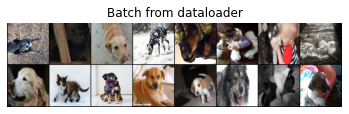

In [ ]:
def show_images(sample):
    #unpack the image/targets from our dataset class(def. above)
    image, target = sample
    #show those images - to make sure that processing so far has gone according to plan
    grid = utils.make_grid(image)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')
#for a sample in our dataloader
for sample in train_dataloader:
  #show the processed images
  plt.figure()
  show_images(sample)
  plt.axis('off')
  plt.ioff()
  plt.show()
  #break after 1 iter - no need/benefit to show any more
  break

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Implementation of a convolutional neural network (CNN)
class ConvNet(nn.Module):
  def __init__(self):
      super(ConvNet, self).__init__()
      # Input should be 3x128x128 (RGB)
      # Layer 1
      self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # Convolutional layer with 3x3 kernel size; outputs 16x128x128
      self.bn1 = nn.BatchNorm2d(16)
      self.relu1 = nn.ReLU() # Activation function
      self.pool1 = nn.MaxPool2d(2, 2) # Pooling layer (downsamples the feature map); outputs 16x64x64

      # Layer 2
      self.conv2= nn.Conv2d(16, 32, kernel_size=3, padding=1) # 32x64x64 
      self.bn2 = nn.BatchNorm2d(32)
      self.relu2 = nn.ReLU()
      self.pool2 = nn.MaxPool2d(2, 2) # 32x32x32

      # Layer 3
      self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 64x32x32
      self.bn3 = nn.BatchNorm2d(64)
      self.relu3 = nn.ReLU()
      self.pool3 = nn.MaxPool2d(2, 2) # 64x16x16

      # Layer 4
      self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 128x16x16
      self.bn4 = nn.BatchNorm2d(128)
      self.relu4 = nn.ReLU()
      self.pool4 = nn.MaxPool2d(2, 2) # 128x8x8
  
      # Layer 5
      self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1) #128x8x8
      self.bn5 = nn.BatchNorm2d(128)
      self.relu5 = nn.ReLU()
      self.pool5 = nn.MaxPool2d(2, 2) #128*4*4

      '''
      self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # 256x8x8
      self.bn5 = nn.BatchNorm2d(256)
      self.relu5 = nn.ReLU()
      self.pool5 = nn.MaxPool2d(2, 2) # 256x4x4
      
      # Layer 6
      self.conv6 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # 512x4x4
      self.bn6 = nn.BatchNorm2d(512)
      self.relu6 = nn.ReLU()
      self.pool6 = nn.MaxPool2d(2, 2) # 512x2x2

      # Flattening layer
      #self.flat = nn.Flatten()'''

      self.fc = nn.Linear(128*4*4, 500)
      #self.fc = nn.Linear(512 * 2 * 2, 500)
      self.relu_fc = nn.ReLU()

      # Output layer for Class Labels and Boxes
      self.out_labels = nn.Linear(500, 1)
      # Output layer for Bounding Boxes
      self.out_boxes = nn.Linear(500, 4)
  
  def forward(self, x):
      
      x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
      #x = self.pool1(self.relu1(self.conv1(x)))
      x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
      #x = self.pool2(self.relu2(self.conv2(x)))
      x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
      #x = self.pool3(self.relu3(self.conv3(x)))
      x = self.pool4(self.relu4(self.bn4(self.conv4(x))))
      #x = self.pool4(self.relu4(self.conv4(x)))
      x = self.pool5(self.relu5(self.bn5(self.conv5(x))))
      #x = self.pool5(self.relu5(self.conv5(x)))
      #x = self.pool6(self.relu6(self.bn6(self.conv6(x))))
      #x = self.pool6(self.relu6(self.conv6(x)))
      
      #x = x.view(-1, 512*2*2)
      x = x.view(-1, 128*4*4)
      x = self.relu_fc(self.fc(x))
      output_labels = self.out_labels(x)
      #output_labels = x[:, :2]
      #output_labels = output_labels.view(output_labels.shape[0], 1)
      #output_boxes = x[:, 2:]
      output_boxes = self.out_boxes(x)

      return torch.sigmoid(output_labels), output_boxes

In [ ]:
model = ConvNet()
print(model)
print('-'*50)
print('Layer Tensor Shapes')
print(model.conv1.weight.shape)
print(model.conv2.weight.shape)
print(model.conv3.weight.shape)
print(model.conv4.weight.shape)
print(model.conv5.weight.shape)
#print(model.conv6.weight.shape)
print(model.fc.weight.shape)
print(model.out_labels.weight.shape)
print(model.out_boxes.weight.shape)

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReL

In [ ]:
#print shape of weight and bias terms for each layer in NN
print('Shape of tensor for each layers weights and bias matrices:','\n')
for name, param in model.named_parameters():
  print(name, '\t', param.shape)

Shape of tensor for each layers weights and bias matrices: 

conv1.weight 	 torch.Size([16, 3, 3, 3])
conv1.bias 	 torch.Size([16])
bn1.weight 	 torch.Size([16])
bn1.bias 	 torch.Size([16])
conv2.weight 	 torch.Size([32, 16, 3, 3])
conv2.bias 	 torch.Size([32])
bn2.weight 	 torch.Size([32])
bn2.bias 	 torch.Size([32])
conv3.weight 	 torch.Size([64, 32, 3, 3])
conv3.bias 	 torch.Size([64])
bn3.weight 	 torch.Size([64])
bn3.bias 	 torch.Size([64])
conv4.weight 	 torch.Size([128, 64, 3, 3])
conv4.bias 	 torch.Size([128])
bn4.weight 	 torch.Size([128])
bn4.bias 	 torch.Size([128])
conv5.weight 	 torch.Size([128, 128, 3, 3])
conv5.bias 	 torch.Size([128])
bn5.weight 	 torch.Size([128])
bn5.bias 	 torch.Size([128])
fc.weight 	 torch.Size([500, 2048])
fc.bias 	 torch.Size([500])
out_labels.weight 	 torch.Size([1, 500])
out_labels.bias 	 torch.Size([1])
out_boxes.weight 	 torch.Size([4, 500])
out_boxes.bias 	 torch.Size([4])


### Manual Gradient Update

In [ ]:
torch.set_grad_enabled(False) #turn off gradients to freeze prop to run a single iteration manually

In [ ]:
#for each batch in the dataloader(loaded above)
batch = next(iter(train_dataloader))
#split out the image and the target(answers
images, targets = batch
#show the shape of 1 batch
print('Shape of a single batch:', images.shape)
#show the predictions of 1 batch
#preds = model(images)
preds = model(images)
class_preds = preds[0]
bbox_preds = preds[1]
print('Shape of class predictions:', class_preds.shape)
print('Class predictions for single batch:', class_preds)
print('Shape of bounding box predictions:', bbox_preds.shape)
print('Bounding box predictions for single batch:', bbox_preds)

Shape of a single batch: torch.Size([16, 3, 128, 128])
Shape of class predictions: torch.Size([16, 1])
Class predictions for single batch: tensor([[0.5262],
        [0.4274],
        [0.5020],
        [0.4636],
        [0.4442],
        [0.4557],
        [0.4775],
        [0.4486],
        [0.4554],
        [0.5309],
        [0.4585],
        [0.5290],
        [0.4743],
        [0.4561],
        [0.5086],
        [0.5260]])
Shape of bounding box predictions: torch.Size([16, 4])
Bounding box predictions for single batch: tensor([[ 7.1182e-02, -5.0127e-01,  7.8443e-02,  3.9801e-01],
        [ 1.8937e-03, -3.5837e-01,  2.9397e-01,  9.7495e-02],
        [ 2.4022e-01, -2.7122e-01, -6.8624e-02,  7.7194e-02],
        [ 2.4154e-01, -2.1862e-01,  1.7716e-01,  1.9650e-01],
        [ 1.0513e-01, -2.6416e-01,  9.1571e-02,  1.1033e-01],
        [ 3.9628e-01, -1.7310e-01,  2.2674e-01,  4.3942e-02],
        [ 3.2168e-01, -1.3195e-01,  2.6818e-03, -4.7473e-02],
        [ 1.0564e-01, -2.7764e-01,  4.97

In [ ]:
# define a function to get the total count of the correct class predictions
def get_num_correct(preds, labels):
    preds = torch.round(preds)
    num_correct = (preds == labels).sum()
    
    #return preds.argmax(dim=-1).eq(labels).sum().item()
    return num_correct

#print(class_preds.argmax(dim=1))
print(get_num_correct(class_preds.squeeze(), targets['labels']))
print(targets['labels'])

tensor(8)
tensor([0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1])


In [ ]:
torch.set_grad_enabled(True) # turn on gradient tracking again to do a back prop

In [ ]:
#set device type based on available hardware
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
torch.cuda.get_device_name(0)

if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")


Torch 1.7.0+cu101 CUDA 10.1
Device: cuda:0


In [ ]:
model = ConvNet()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer.step() #update weights and bias
mse = nn.MSELoss()
bce = nn.BCELoss()

#labels = labels.view(labels.shape[0], 1)
labels = targets['labels'].to(device) # Push target labels to device
labels = labels.type(torch.cuda.FloatTensor)
boxes = targets['boxes'].to(device)
images = images.to(device) # Push images to device
model = model.to(device)
output_labels, output_boxes = model(images)
output_labels = output_labels.squeeze()
#output_labels = torch.round(output_labels)
#output_boxes = model(images).to(device)

#loss_classifier = F.cross_entropy(output_labels, labels) # Calculate loss function for classification
loss_classifier = bce(output_labels, labels)
loss_boxes = mse(output_boxes, boxes)
print(loss_classifier)
print(loss_boxes)
loss = loss_classifier + loss_boxes
print("Updated loss after backpropagation", loss.item())
print(labels)
print(output_labels)

tensor(0.6871, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3989, device='cuda:0', grad_fn=<MseLossBackward>)
Updated loss after backpropagation 1.0859875679016113
tensor([0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
       device='cuda:0')
tensor([0.6144, 0.5676, 0.5781, 0.5929, 0.5966, 0.5813, 0.6566, 0.5378, 0.6045,
        0.5676, 0.5853, 0.5913, 0.5526, 0.5583, 0.5853, 0.5805],
       device='cuda:0', grad_fn=<SqueezeBackward0>)


### Training Loop for CNN

Start Epoch 
 --------------------------------------------------
Batch: 0 loss: 1.1663415431976318 accuracy: 0.609375
Batch: 50 loss: 1.1591557264328003 accuracy: 0.46875
Batch: 100 loss: 1.1828570365905762 accuracy: 0.484375
Batch: 150 loss: 1.130753755569458 accuracy: 0.671875
Epoch: 0 Average accuracy: 0.5599254261363636 Average correct preds: 35.57954545454545 Average epoch loss: 1.1581697768785737
Batch: 0 loss: 1.159743070602417 accuracy: 0.546875
Batch: 25 loss: 1.140035629272461 accuracy: 0.59375
Epoch: 0 Average accuracy: 0.5499526515151515 Average correct preds: 35.02272727272727 Average epoch loss: 1.156895873221484
Start Epoch 
 --------------------------------------------------
Batch: 0 loss: 1.1584986448287964 accuracy: 0.484375
Batch: 50 loss: 1.164440631866455 accuracy: 0.609375
Batch: 100 loss: 1.1474730968475342 accuracy: 0.5625
Batch: 150 loss: 1.1130478382110596 accuracy: 0.671875
Epoch: 1 Average accuracy: 0.5582386363636364 Average correct preds: 35.47159090909091

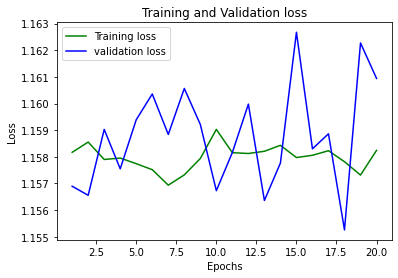

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001) # Using Adam for better performance
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
criterion = nn.MSELoss() # Set MSE loss for boxes
bce = nn.BCELoss()

#init data loaders for train/test
train_dataloader = DataLoader(dataset, batch_size=64, sampler=train_sampler, pin_memory=True)
test_dataloader = DataLoader(dataset, batch_size=64, sampler=test_sampler, pin_memory=True)
#iter 20 times
num_epochs = 20
loss_vals = []
accuracy_vals = []
loss_vals_test = []
accuracy_vals_test = []
model = ConvNet()
model = model.to(device)
for epoch in range(num_epochs):
  print('Start Epoch','\n','-'*50)
  with torch.set_grad_enabled(True):
  # Initialize some counter values
    total_loss = 0
    total_correct = 0
    total_accuracy = 0
    #model = ConvNet()
    model.train()
    for idx, batch in enumerate(train_dataloader):
      images, targets = batch # Load images and targets
      labels = targets['labels'].to(device) # Push target labels to GPU
      boxes = targets['boxes'].to(device)
      images = images.to(device)
      #model = model.to(device) # Push images to GPU
      labels = labels.type(torch.cuda.FloatTensor)
      output_labels, output_boxes = model(images)
      output_labels = output_labels.squeeze()
      #loss_classifier = F.cross_entropy(output_labels, labels) # Calculate loss function for classification
      loss_classifier = bce(output_labels, labels)
      loss_boxes = criterion(output_boxes, boxes) # Calculate loss function for regression
      loss = loss_classifier + loss_boxes # Sum
      optimizer.zero_grad() # Zero the gradient
      loss.backward() # Run backpropagation to calculate the gradient
      optimizer.step() # Run gradient update

      batch_loss = loss.item() # Get loss per batch as number instead of tensor
      total_loss += batch_loss
      batch_correct = get_num_correct(output_labels, labels).item()
      total_correct += batch_correct
      accuracy = batch_correct / labels.size(0)
      total_accuracy += accuracy
      if idx%50 == 0:
        print('Batch:', idx, 'loss:', batch_loss, 'accuracy:', accuracy)
  
    avg_accuracy = total_accuracy/(idx+1)
    avg_loss = total_loss/(idx+1)
    accuracy_vals.append(avg_accuracy)
    loss_vals.append(avg_loss)

    print('Epoch:', epoch, 'Average accuracy:', avg_accuracy, 
          'Average correct preds:', total_correct/(idx+1), 'Average epoch loss:', avg_loss)
  
  # Run validation set
  with torch.no_grad():
    val_total_loss = 0
    val_total_correct = 0
    val_total_accuracy = 0
    model.eval()
    for idx, batch in enumerate(test_dataloader):
      images, targets = batch
      val_labels = targets['labels'].to(device)
      val_labels = val_labels.type(torch.cuda.FloatTensor)
      val_boxes = targets['boxes'].to(device)
      images = images.to(device)
      #model = model.to(device) # Push images to GPU
      output_labels, output_boxes = model(images)
      output_labels = output_labels.squeeze()
      loss_classifier = bce(output_labels, val_labels)
      #loss_classifier = F.cross_entropy(output_labels, val_labels) # Calculate loss function for classification
      loss_boxes = criterion(output_boxes, val_boxes) 
      loss = loss_classifier + loss_boxes
      #get loss
      batch_loss = loss.item()
      val_total_loss += batch_loss
      batch_correct = get_num_correct(output_labels, val_labels).item()
      val_total_correct += batch_correct
      accuracy = batch_correct / val_labels.size(0)
      val_total_accuracy += accuracy
      if idx%25 == 0:
        print('Batch:', idx, 'loss:', batch_loss, 'accuracy:', accuracy)

    val_avg_accuracy = val_total_accuracy/(idx+1)
    val_avg_loss = val_total_loss/(idx+1)
    accuracy_vals_test.append(val_avg_accuracy)
    loss_vals_test.append(val_avg_loss)
  
    print('Epoch:', epoch, 'Average accuracy:', val_avg_accuracy, 
          'Average correct preds:', val_total_correct/(idx+1), 'Average epoch loss:', val_avg_loss)
  
epochs = range(1, num_epochs+1)
plt.plot(epochs, loss_vals, 'g', label='Training loss')
plt.plot(epochs, loss_vals_test, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

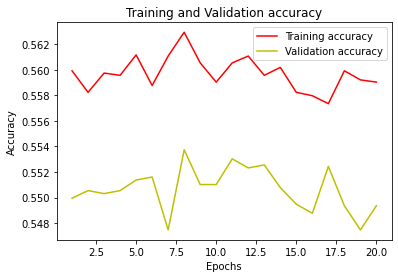

In [ ]:
epochs = range(1, num_epochs+1)
plt.plot(epochs, accuracy_vals, 'r', label='Training accuracy')
plt.plot(epochs, accuracy_vals_test, 'y', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_loader = DataLoader(test_ds, batch_size=batch_size, 
                        shuffle=True, num_workers=0, drop_last=True)

box_reg_loss = nn.L1Loss(reduction='sum')

with torch.no_grad:
  model.eval()
  regression_loss = 0
  num_correct = 0

  for idx, batch in enumerate(test_loader):
    x, y = batch
    y_bb = y['box_info']
    y_label = y['labels']

    x, y_bb, y_label = x.to(device), y_bb.to(device), y_class.to(device)
    model_rn.to(device)
    outputs = model_rn(x)

    bb_loss = box_reg_loss(outputs[1], y_bb)/4.0
    class_loss = label_loss(outputs[0], y_label)

    regression_loss += bb_loss.item()

    batch_correct = get_num_correct(outputs[0], y_label)
    test_total_correct += batch_correct
    accuracy = batch_correct / test_labels.size(0)
    test_total_accuracy += accuracy

    print(f'Test Bounding Box Loss: {bb_loss}, Test Classifier Accuracy: {accuracy}')

  total_accuracy = test_total_accuracy/len(test_loader)
  total_reg_loss = regression_loss/len(test_loader)
  print(f'Total Bounding Box Loss: {total_reg_loss}, Total Classifier Accuracy:{otal_accuracy}')

### FCN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Implementation of a fully convolutional neural network (FCN)
class FullConvNet(nn.Module):
  def __init__(self):
      super(FullConvNet, self).__init__()
      # Input should be 1x128x128 (grayscale)
      # Layer 1
      self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1) # Convolutional layer with 3x3 kernel size; outputs 16x128x128
      self.bn1 = nn.BatchNorm2d(16)
      self.relu1 = nn.ReLU() # Activation function
      self.pool1 = nn.MaxPool2d(2, 2) # Pooling layer (downsamples the feature map); outputs 16x64x64

      # Layer 2
      self.conv2= nn.Conv2d(16, 32, kernel_size=3, padding=1) # 32x64x64 
      self.bn2 = nn.BatchNorm2d(32)
      self.relu2 = nn.ReLU()
      self.pool2 = nn.MaxPool2d(2, 2) # 32x32x32

      # Layer 3
      self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 64x32x32
      self.bn3 = nn.BatchNorm2d(64)
      self.relu3 = nn.ReLU()
      self.pool3 = nn.MaxPool2d(2, 2) # 64x16x16

      # Layer 4
      self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 128x16x16
      self.bn4 = nn.BatchNorm2d(128)
      self.relu4 = nn.ReLU()
      self.pool4 = nn.MaxPool2d(2, 2) # 128x8x8

      # Layer 5
      self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # 256x8x8
      self.bn5 = nn.BatchNorm2d(256)
      self.relu5 = nn.ReLU()
      self.pool5 = nn.MaxPool2d(2, 2) # 256x4x4
      
      # Layer 6
      self.conv6 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # 512x4x4
      self.bn6 = nn.BatchNorm2d(512)
      self.relu6 = nn.ReLU()
      self.pool6 = nn.MaxPool2d(2, 2) # 512x2x2
      
      # Layer 7
      self.out_labels = nn.Conv2d(512, 2, kernel_size=1, padding=1) # 2x2x2
      self.labels_relu = nn.ReLU()
      self.out_labels_pool = nn.AvgPool2d(4)
      # Layer 8
      self.out_boxes = nn.Conv2d(512, 4, kernel_size=1, padding=1) # 4x2x2
      self.boxes_relu = nn.ReLU()
      self.out_boxes_pool = nn.AvgPool2d(4)
      # Flattening layer
      #self.flat = nn.Flatten()

  
  def forward(self, x):
      x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
      #x = self.pool1(self.relu1(self.conv1(x)))
      #x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
      x = self.pool2(self.relu2(self.conv2(x)))
      #x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
      x = self.pool3(self.relu3(self.conv3(x)))
      x = self.pool4(self.relu4(self.bn4(self.conv4(x))))
      #x = self.pool4(self.relu4(self.conv4(x)))
      #x = self.pool5(self.relu5(self.bn5(self.conv5(x))))
      x = self.pool5(self.relu5(self.conv5(x)))
      x = self.pool6(self.relu6(self.bn6(self.conv6(x))))
      #x = self.pool6(self.relu6(self.conv6(x)))

      #x = self.pool5(self.drop1(x))
      #x = self.pool6(self.drop2(x))
      #x = self.flat(x)
      #x = x.view(-1, 2048)
      output_labels = self.out_labels(x)
      output_labels = self.out_labels_pool(output_labels)
      output_labels = output_labels.squeeze()
      output_boxes = self.out_boxes(x)
      output_boxes = self.out_boxes_pool(output_boxes)
      output_boxes = output_boxes.squeeze()
      #output = self.pool7(self.relu7(self.conv7(x)))
      # Not sure yet if every layer needs pooling
      return output_labels, output_boxes

In [ ]:
model = FullConvNet()
print(model)
print('-'*50)
print('Layer Tensor Shapes')
print(model.conv1.weight.shape)
print(model.conv2.weight.shape)
print(model.conv3.weight.shape)
print(model.conv4.weight.shape)
print(model.conv5.weight.shape)
print(model.conv6.weight.shape)
#print(model.conv7.weight.shape)
#print(model.conv8.weight.shape)
print(model.out_labels.weight.shape)
print(model.out_boxes.weight.shape)

FullConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [ ]:
#print shape of weight and bias terms for each layer in NN
print('Shape of tensor for each layers weights and bias matrices:','\n')
for name, param in model.named_parameters():
  print(name, '\t', param.shape)

Shape of tensor for each layers weights and bias matrices: 

conv1.weight 	 torch.Size([16, 1, 3, 3])
conv1.bias 	 torch.Size([16])
bn1.weight 	 torch.Size([16])
bn1.bias 	 torch.Size([16])
conv2.weight 	 torch.Size([32, 16, 3, 3])
conv2.bias 	 torch.Size([32])
bn2.weight 	 torch.Size([32])
bn2.bias 	 torch.Size([32])
conv3.weight 	 torch.Size([64, 32, 3, 3])
conv3.bias 	 torch.Size([64])
bn3.weight 	 torch.Size([64])
bn3.bias 	 torch.Size([64])
conv4.weight 	 torch.Size([128, 64, 3, 3])
conv4.bias 	 torch.Size([128])
bn4.weight 	 torch.Size([128])
bn4.bias 	 torch.Size([128])
conv5.weight 	 torch.Size([256, 128, 3, 3])
conv5.bias 	 torch.Size([256])
bn5.weight 	 torch.Size([256])
bn5.bias 	 torch.Size([256])
conv6.weight 	 torch.Size([512, 256, 3, 3])
conv6.bias 	 torch.Size([512])
bn6.weight 	 torch.Size([512])
bn6.bias 	 torch.Size([512])
out_labels.weight 	 torch.Size([2, 512, 1, 1])
out_labels.bias 	 torch.Size([2])
out_boxes.weight 	 torch.Size([4, 512, 1, 1])
out_boxes.bias 	 to

In [ ]:
#for each batch in the dataloader(loaded above)
batch = next(iter(train_dataloader))
#split out the image and the target(answers
images, targets = batch
#show the shape of 1 batch
print('Shape of a single batch:', images.shape)
#show the predictions of 1 batch
#preds = model(images)
preds = model(images)
class_preds = preds[0]
bbox_preds = preds[1]
print('Shape of class predictions:', class_preds.shape)
print('Class predictions for single batch:', class_preds)
print('Shape of bounding box predictions:', bbox_preds.shape)
print('Bounding box predictions for single batch:', bbox_preds)

Shape of a single batch: torch.Size([64, 1, 128, 128])
Shape of class predictions: torch.Size([64, 2])
Class predictions for single batch: tensor([[-0.0034,  0.0367],
        [ 0.0140, -0.0280],
        [-0.0504, -0.0127],
        [-0.0380,  0.0320],
        [ 0.0184, -0.0123],
        [ 0.0001, -0.0027],
        [-0.0746, -0.0331],
        [-0.0188, -0.0110],
        [-0.0098, -0.0544],
        [ 0.0771,  0.0126],
        [-0.0335, -0.1028],
        [-0.0035, -0.0303],
        [-0.1012, -0.0233],
        [-0.0008, -0.0026],
        [ 0.0030, -0.0959],
        [-0.0152, -0.0009],
        [-0.0356,  0.0246],
        [-0.0188,  0.0228],
        [-0.0400, -0.0479],
        [-0.0415, -0.1155],
        [-0.0681,  0.0145],
        [-0.0080, -0.0684],
        [-0.0402,  0.0333],
        [-0.1142,  0.0479],
        [-0.0678, -0.0350],
        [-0.0572, -0.0339],
        [ 0.0860, -0.0131],
        [-0.0561, -0.0018],
        [ 0.0086,  0.0716],
        [-0.0053, -0.0152],
        [ 0.0451, -0.

In [ ]:
torch.set_grad_enabled(False) #turn off gradients to freeze prop to run a single iteration manually

In [ ]:
#for each batch in the dataloader(loaded above)
batch = next(iter(train_dataloader))
#split out the image and the target(answers
images, targets = batch
#show the shape of 1 batch
print('Shape of a single batch:', images.shape)
#show the predictions of 1 batch
#preds = model(images)
preds = model(images)
class_preds = preds[0]
bbox_preds = preds[1]
print('Shape of class predictions:', class_preds.shape)
print('Class predictions for single batch:', class_preds)
print('Shape of bounding box predictions:', bbox_preds.shape)
print('Bounding box predictions for single batch:', bbox_preds)

Shape of a single batch: torch.Size([64, 1, 128, 128])
Shape of class predictions: torch.Size([64, 2])
Class predictions for single batch: tensor([[ 0.0146,  0.0251],
        [-0.0430,  0.0353],
        [ 0.0007, -0.0195],
        [ 0.0170, -0.0055],
        [ 0.0164, -0.0440],
        [ 0.0526, -0.0373],
        [-0.0605, -0.0217],
        [ 0.0273, -0.0936],
        [-0.0409, -0.0379],
        [-0.0766,  0.0036],
        [-0.0423,  0.0172],
        [-0.0180,  0.0177],
        [-0.0427,  0.0082],
        [ 0.0519, -0.0997],
        [ 0.0296, -0.0293],
        [-0.0377,  0.0399],
        [-0.0695, -0.0564],
        [-0.0319,  0.0123],
        [ 0.0146,  0.0272],
        [-0.0430,  0.0217],
        [-0.0305, -0.0786],
        [ 0.0683, -0.0152],
        [ 0.0444, -0.0391],
        [-0.0400, -0.0296],
        [-0.0839, -0.0344],
        [-0.0205,  0.0069],
        [-0.0906,  0.0075],
        [-0.0422,  0.0007],
        [-0.0509, -0.0792],
        [-0.0340,  0.0294],
        [-0.0509, -0.

In [ ]:
# define a function to get the total count of the correct class predictions

def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

print(class_preds.argmax(dim=1))
print(targets['labels'])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0])


In [ ]:
torch.set_grad_enabled(True) # turn on gradient tracking again to do a back prop

In [ ]:
#set device type based on available hardware
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
torch.cuda.get_device_name(0)

if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")


Torch 1.7.0+cu101 CUDA 10.1
Device: cuda:0


In [ ]:
model = ConvNet()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer.step() #update weights and bias
mse = nn.MSELoss()

labels = targets['labels'].to(device) # Push target labels to device
boxes = targets['boxes'].to(device)
images = images.to(device) # Push images to device
model = model.to(device)
output_labels, output_boxes = model(images)
#output_boxes = model(images).to(device)

loss_classifier = F.cross_entropy(output_labels, labels) # Calculate loss function for classification
loss_boxes = mse(output_boxes, boxes) 
loss = loss_classifier + loss_boxes
print("Updated loss after backpropagation", loss.item())

Updated loss after backpropagation 1.193626880645752


Start Epoch 
 --------------------------------------------------
Batch: 0 loss: 1.1151567697525024 accuracy: 0.671875
Batch: 50 loss: 1.1663262844085693 accuracy: 0.421875
Batch: 100 loss: 1.1333191394805908 accuracy: 0.546875
Batch: 150 loss: 1.1248273849487305 accuracy: 0.546875
Epoch: 0 Average accuracy: 0.5541548295454546 Average correct preds: 35.29545454545455 Average epoch loss: 1.1303410408171741
Batch: 0 loss: 1.14292573928833 accuracy: 0.515625
Batch: 25 loss: 1.1292427778244019 accuracy: 0.59375
Epoch: 0 Average accuracy: 0.5615530303030303 Average correct preds: 35.75 Average epoch loss: 1.1265686506574804
Start Epoch 
 --------------------------------------------------
Batch: 0 loss: 1.1368188858032227 accuracy: 0.46875
Batch: 50 loss: 1.1204595565795898 accuracy: 0.578125
Batch: 100 loss: 1.1314501762390137 accuracy: 0.5625
Batch: 150 loss: 1.155405044555664 accuracy: 0.5
Epoch: 1 Average accuracy: 0.5553089488636364 Average correct preds: 35.28409090909091 Average epoch 

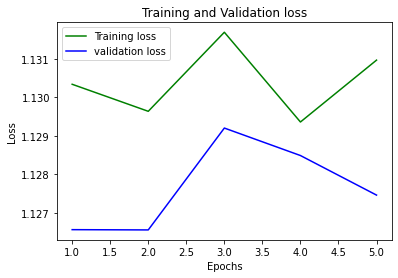

In [ ]:
#optimizer = optim.Adam(model.parameters(), lr=0.01) # Using Adam for better performance
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.MSELoss() # Set MSE loss for boxes

#init data loaders for train/test
train_dataloader = DataLoader(dataset, batch_size=64, sampler=train_sampler, pin_memory=True)
test_dataloader = DataLoader(dataset, batch_size=64, sampler=test_sampler, pin_memory=True)
#iter 5 times
num_epochs = 5
loss_vals = []
accuracy_vals = []
loss_vals_test = []
accuracy_vals_test = []
model = FullConvNet()
model = model.to(device)
for epoch in range(num_epochs):
  print('Start Epoch','\n','-'*50)
  # Initialize some counter values
  total_loss = 0
  total_correct = 0
  total_accuracy = 0
  #model = ConvNet()
  for idx, batch in enumerate(train_dataloader):
    model.train()
    images, targets = batch # Load images and targets
    labels = targets['labels'].to(device) # Push target labels to GPU
    boxes = targets['boxes'].to(device)
    images = images.to(device)
    #model = model.to(device) # Push images to GPU
    output_labels, output_boxes = model(images)
    loss_classifier = F.cross_entropy(output_labels, labels) # Calculate loss function for classification
    loss_boxes = criterion(output_boxes, boxes) # Calculate loss function for regression
    loss = loss_classifier + loss_boxes # Sum
    optimizer.zero_grad() # Zero the gradient
    loss.backward() # Run backpropagation to calculate the gradient
    optimizer.step() # Run gradient update
    
    batch_loss = loss.item() # Get loss per batch as number instead of tensor
    total_loss += batch_loss
    batch_correct = get_num_correct(output_labels, labels)
    total_correct += batch_correct
    accuracy = batch_correct / labels.size(0)
    total_accuracy += accuracy
    if idx%50 == 0:
      print('Batch:', idx, 'loss:', batch_loss, 'accuracy:', accuracy)
  
  avg_accuracy = total_accuracy/(idx+1)
  avg_loss = total_loss/(idx+1)
  accuracy_vals.append(avg_accuracy)
  loss_vals.append(avg_loss)

  print('Epoch:', epoch, 'Average accuracy:', avg_accuracy, 
        'Average correct preds:', total_correct/(idx+1), 'Average epoch loss:', avg_loss)
  
  # Run validation set
  with torch.no_grad():
    val_total_loss = 0
    val_total_correct = 0
    val_total_accuracy = 0

    for idx, batch in enumerate(test_dataloader):
      model.eval()
      images, targets = batch
      val_labels = targets['labels'].to(device)
      val_boxes = targets['boxes'].to(device)
      images = images.to(device)
      #model = model.to(device) # Push images to GPU
      output_labels, output_boxes = model(images)
      loss_classifier = F.cross_entropy(output_labels, val_labels) # Calculate loss function for classification
      loss_boxes = criterion(output_boxes, val_boxes) 
      loss = loss_classifier + loss_boxes
      #get loss
      batch_loss = loss.item()
      val_total_loss += batch_loss
      batch_correct = get_num_correct(output_labels, val_labels)
      val_total_correct += batch_correct
      accuracy = batch_correct / val_labels.size(0)
      val_total_accuracy += accuracy
      if idx%25 == 0:
        print('Batch:', idx, 'loss:', batch_loss, 'accuracy:', accuracy)

    val_avg_accuracy = val_total_accuracy/(idx+1)
    val_avg_loss = val_total_loss/(idx+1)
    accuracy_vals_test.append(val_avg_accuracy)
    loss_vals_test.append(val_avg_loss)
  
    print('Epoch:', epoch, 'Average accuracy:', val_avg_accuracy, 
          'Average correct preds:', val_total_correct/(idx+1), 'Average epoch loss:', val_avg_loss)
  
epochs = range(1, num_epochs+1)
plt.plot(epochs, loss_vals, 'g', label='Training loss')
plt.plot(epochs, loss_vals_test, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Results

In the last stage of our cat and dog image detection project, we loaded, cleaned, and preprocessed our cat and dog image dataset, then created baseline models for each individual machine learning task: logistic regression for the image classification task, and LASSO linear regression for the bounding box regression task. As image detection is a very complex problem with a very large number of features to learn, these models did not perform particularly well, though this was expected. In the second stage, we hoped to improve performance by moving to a neural network implemented in PyTorch.
	
We created a generic feedforward neural network with three hidden layers (consisting of 500 neurons each) to start with, using ReLU as an activation function. While we were aware that convolutional neural networks offer significant performance gains in image classification and detection tasks, it was important first to get baseline results with a more generic model. This model used a custom loss function consisting of the sum of cross-entropy loss and mean squared error, allowing both the classification and regression tasks to be learned with the same gradient. Performance on this model was at about 56% accuracy on the test set.  When dropout layers were added, model performance did not improve, but found the local minimum more quickly.  The model was able to quickly find the local minimum after only two of ten epochs. We additionally allowed the model to train for twenty epochs, but there was no statistically significant change, with the same average performance per epoch on the training set (55%) and testing set (56%) as the ten-epoch run. We additionally found that a learning rate of 0.001 and a batch size of 32 were ideal, with any adjustments leading to worse performance. 

While we did not have any estimates for the performance of this model due to the relative inexperience of the group with deep learning, we were surprised to see a lack of improvement over our baseline models. However, after beginning work on a convolutional neural network early, it became clear what at least part of the issue was. Convolutional neural networks learn features consisting of patterns of neighboring pixels (at least in the case of image data), allowing for salient shape features to be learned. Standard neural networks, on the other hand, learn individual pixels, and not all pixels in an image are actually useful for this task: there is a considerable amount of noise in each image, at least from the perspective of identifying cats and dogs. As such, there are thousands of essentially useless features a standard neural network nevertheless has to contend with, making training take longer and creating a more difficult gradient to traverse. While dimensionality reduction can no doubt improve performance, it seems clear that a convolutional neural network is the optimal solution.


## Generic Training Loop with Grid Search Parameters

In [ ]:
from collections import OrderedDict
from collections import namedtuple
from itertools import product

params = OrderedDict(
    lr = [0.01, 0.001],
    device = ['cuda'],
    batch_size = [64, 128, 512]
)

# creates a class to iterate oevr the various hyper parameters and assign the 
# hyper params to a run combination
class IterateRuns():
  def get_runs(params):
    run = namedtuple('Run', params.keys())

    runs = []

    for i in product(*params.values()):
      runs.append(run(*i))
    return runs

# Show all run combinations that will be run 
for run in IterateRuns.get_runs(params):
  print(f'{run}')

Run(lr=0.01, device='cuda', network='lin_oop')
Run(lr=0.001, device='cuda', network='lin_oop')


### Results Tracking Class To Create Run Dataframe

In [ ]:
# Creates a class for the epoch and run tracking metrics
# defines functions for the start and end of epochs and runs
from time import time

class ResultsCreator():
  def __init__(self):
    self.e_count = 0
    self.e_loss = 0
    self.e_startTime = None
    self.e_correct_count = 0

    self.r_count = 0
    self.r_params = 0 
    self.r_data = 0
    self.r_startTime = None

    self.network = None
    self.dataLoader = None

  def start_run(self, loader, network, run):
    self.r_startTime = time()
    self.r_count += 1
    self.network = network
    self.dataLoader = loader


    batch = next(iter(loader))
    images, targets = batch
    labels = targets['labels']
    boxes = targets['boxes']

    desc = f'{run}'

  def end_run(self):
    self.e_count = 0

  def start_epoch(self):
    self.e_startTime = time()
    self.e_count += 1
    self.e_loss = 0
    self.e_correct_count =0

  def end_epoch(self):
    e_run_time = time() - self.e_startTime 
    r_run_time = time() - self.r_startTime

    loss = self.e_loss/len(self.dataLoader.dataset)
    accuracy = self.e_correct_count/len(self.dataLoader.dataset)

    results = OrderedDict(
        run = self.r_count,
        epoch = self.e_count,
        run_time = r_run_time,
        epoch_time = e_run_time,
        loss = loss,
        accuracy = accuracy
    )

    for keys, values in self.r_params._asdict().items():
      results[keys] = values
      self.r_data.append(results)

    df = pd.DataFrame.from_dict(self.r_data)

    return df


### Generic Training Loop Implementation

In [ ]:
rc = ResultsCreator()

if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

for run in IterateRuns.get_runs(params):

  network = LinNet()
  data = torch.utils.data.DataLoader(dataset, batch_size=64, sampler=train_sampler)
  optimizer = torch.optim.Adam(network.parameters(),lr = run.lr)
  loss_vals = []
  accuracy_vals = []
  rc.start_run(data, network, run)
  for epoch in range(3):
    rc.start_epoch()

    for batch in data:
      images, targets = batch # Load images and targets
      labels = targets['labels'].to(device) # Push target labels to GPU
      boxes = targets['boxes'].to(device)
      images = images.to(device)
      model = model.to(device) # Push images to GPU
      outputs = model(images)
      loss_classifier = F.cross_entropy(outputs[0], labels) # Calculate loss function for classification
      loss_boxes = criterion(outputs[1], boxes) 
      total_loss = loss_classifier + loss_boxes
      optimizer.zero_grad() # Zero the gradient
      total_loss.backward() # Run backpropagation to calculate the gradient
      optimizer.step() # Run gradient update
      
      batch_loss = loss_classifier.item() + loss_boxes.item()
      total_loss += batch_loss
      batch_correct = get_num_correct(output_labels, labels)
      total_correct += batch_correct
      #total_correct += get_num_correct(preds, target['labels'])
      accuracy = batch_correct / labels.size(0)
      total_accuracy += accuracy
      if idx%5 == 0:
        #print('Batch:', idx, 'loss:', total_loss)
        print('Batch:', idx, 'loss:', batch_loss, 'accuracy:', accuracy)

    print('Epoch:', epoch, 'Average accuracy:', total_accuracy/(idx+1), 
          'Average correct preds:', total_correct/(idx+1), 'Average epoch loss:', 
          total_loss/(idx+1))

    rc.end_epoch()

  rc.end_run()

NameError: ignored

# Conclusion

In Phase 1 the team struggled to get a handle on the data and creating a baseline model that combined loss values from bounding box and classifier predictions. At the end of phase 1 the team successfully developed a notebook that automates the preprocessing steps to transform image data and has a baseline LR model to compare future progress against. The team found this approach to be slow and cost intensive. In Phase 2 the team implemented a training approach based on the PyTorch framework to satisfy our hypothesis that a NN would outperform a baselin linear regression model. The goal of this phase was to implement a linear neural network in PyTorch that was trained on the image dataset for classifying cats and dogs and detecting the obejct in the image. The team implemented a new transformation method that composed a transformation method to batch transform all the data in the dataset at once. We also experimented with running on the cpu and gpu. Our results showed that the GPU ran faster and allowed us to refine our layers more quickly. The team was able to experiment with multiple methods of network implementation by creating a network class and a sequential network. The architectures were exactly the same, but the implementation difference focuses around just in time usage of the layers vs. initializing and defining a full class. The sequential network has the forward pass function built into the layers. The team created a combined loss function that combines the MSE loss for the bounding box predictions and the Cross Entropy loss to be able to pass back the proper gradient to account for the prediction on both outputs. Our average loss and accuracy for each epoch in our training loop for the network hovered around ~50-60% for both. We think this is about the maximum performance we can receive with a linear NN. We saw an increase in performance by introducing two drop out layers to normalize the weight updates and make sure that the neurons with the most impact are properly weighted. Our next steps to improve performance further are to introduce a convolutional neural network instead of a linear network to create a defined feature map and identify distinctive features before flattening the image to pass through linear layers. We believe that the identification of distinct features in the image will result in higher accuracy vs just passing the image pixel data. The team will also attempt to implement an OOP approach to managing the number of runs to create a grid search-type implementation for hyperparameter tuning.

In Phase 3, the team implemented two approaches to convolutional neural networks: a residual learning model using ResNet50, a pretrained deep convolutional network; and a homegrown (and considerably more shallow) convolutional network. Initially, we had thought a network with 7 convolutional layers and two linear output layers would work; however, the rapid increase in the output features in each layer may have worked against us. While it may have eventually converged, it might have taken a large number of epochs (>20) to do so. Moving to a network that has subsequent layers with equal numbers of output features might allow the features to be better learned.